In [1]:
from smach_utils2 import *
import matplotlib.pyplot as plt
#arm = moveit_commander.MoveGroupCommander('arm')


/home/roboworks/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
arm=moveit_commander.MoveGroupCommander('arm')

[ WARN] [1714759650.692231440]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1714759650.696073304]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1714759650.696113909]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1714759650.697109405]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1714759650.697141189]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1714759651.237628562]: Kinematics solver doesn't support #attempts any

In [ ]:

whole_body=moveit_commander.MoveGroupCommander('whole_body_weighted')

In [ ]:
res = omni_base.move_base(known_location='place_shelf', time_out=200)
high_shelf_place=np.asarray([0.15050079265248406,
 -0.5861087653247212,
 0.0850017715788356,
 -0.9342371117035135,
 0.022035143687695324,
 0.0])
mid_shelf_place=np.asarray([0.2556342351169577,
 -1.6040815280188854,
 -0.008078345343693893,
 -0.05795663028496589,
 0.0019971082238159354,
 0.0])

low_shelf_place=np.asarray([0.04577467546491997,
 -2.262541528018885,
 0.00010865465630605087,
 0.701618369715034,
 -0.0003068917761841483,
 0.0]
)

In [3]:
head.set_joint_values([-0.5,-0.65])
arm.set_named_target('go')
arm.go()

True

In [4]:

rospy.sleep(0.6)
rospy.sleep(0.6)
image= cv2.cvtColor(rgbd.get_image(), cv2.COLOR_RGB2BGR)
img_msg  = bridge.cv2_to_imgmsg(image)
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
debug_image=   cv2.cvtColor(bridge.imgmsg_to_cv2(res.debug_image.image_msgs[0]), cv2.COLOR_RGB2BGR)

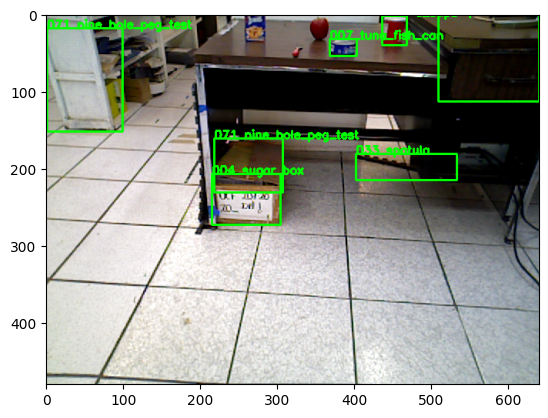

In [5]:

plt.imshow(debug_image)

#############Finding placing in plane#################### 0.0
Placing Area at (2.5974535942077637, 0.29928675293922424, 0.47744131088256836, 2.6500003337860107, 0.6455662846565247, 0.4521332085132599)


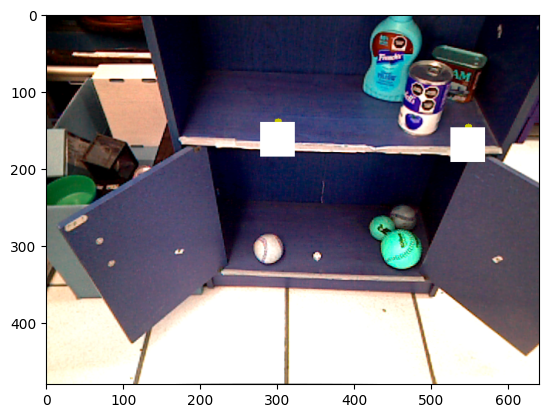

In [10]:
request= segmentation_server.request_class() 



request.height.data=-1  #MID SHELF FOR PLACING 


res=placing_finder_server.call(request)
#succ=seg_res_tf(res)
print (f'Placing Area at {res.poses.data}')
tf_man.pub_static_tf(pos=[res.poses.data[0], res.poses.data[1],res.poses.data[2]], rot =[0,0,0,1], point_name='placing_area')
img=bridge.imgmsg_to_cv2(res.im_out.image_msgs[0])
#cv2.imshow('our of res'  , img)
plt.imshow(img)

In [8]:
res = omni_base.move_base(known_location='place_shelf', time_out=12)


header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 0.0
  y: 0.0
  yaw: 0.0
  timeout: 12
  known_location: "place_shelf"


In [ ]:
base_grasp_D(tf_name='placing_area',d_x=0.76, d_y=0.0,timeout=30)
arm.go (mid_shelf_place)
base_grasp_D(tf_name='placing_area',d_x=0.6, d_y=0.0,timeout=30)
gripper.open()

In [ ]:
arm.go (mid_shelf_place)

In [ ]:
base_grasp_D(tf_name='placing_area',d_x=0.6, d_y=0.0,timeout=30)
gripper.open()

In [ ]:

for i in range(len(res.poses)):
    tf_man.getTF("head_rgbd_sensor_rgb_frame")
    tf_man.pub_static_tf(pos=[res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z], rot=[0,0,0,1],ref="head_rgbd_sensor_rgb_frame",point_name=res.names[i].data[4:] )   
    rospy.sleep(0.3)
    tf_man.change_ref_frame_tf(res.names[i].data[4:])



In [ ]:
omni_base.move_d_to(target_distance=0.78,target_link='apple')

In [ ]:
target_object='apple'
trans,_=tf_man.getTF(target_object,ref_frame="base_link")
trans


In [ ]:
target_object='apple'
_,rot= tf_man.getTF("base_link",ref_frame='map')

original_rot=tf.transformations.euler_from_quaternion(rot)[2]
trans,_=tf_man.getTF(target_object,ref_frame="base_link")


trans , original_rot

In [ ]:
_,rot= tf_man.getTF("base_link",ref_frame='map')
original_rot=tf.transformations.euler_from_quaternion(rot)[2]
target_object='apple'


succ = False
            
while not succ:
    
    _,rot= tf_man.getTF("base_link",ref_frame='map')
    trans,_=tf_man.getTF(target_object,ref_frame="base_link")

    trans
    eX, eY, eZ = trans
    
    eX+= -0.4
    eY+= -.06
    
    eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
    print (eT)
    if eT > np.pi: eT=-2*np.pi+eT
    if eT < -np.pi: eT= 2*np.pi+eT
    rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
    X, Y, Z = trans
    rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
    
    if abs(eX) <=0.05 :
        print ('here')
        eX = 0
    if abs(eY) <=0.05  :
        eY = 0
    if abs(eT   ) < 0.1:
        eT = 0
    succ =  eX == 0 and eY == 0 and eT==0

    
    omni_base.tiny_move( velX=0.2*+eX,velY=0.3*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 


In [ ]:
res.names

In [ ]:
hand_cam= HAND_RGB()


In [ ]:
#clear_octo_client()

pickup_pose=[0.65,-1.2,0.0,-1.9, 0.0, 0.0]
succ= arm.go(pickup_pose)
gripper.open()


In [ ]:

image= cv2.cvtColor(hand_cam.get_image(), cv2.COLOR_RGB2BGR)
img_msg  = bridge.cv2_to_imgmsg(image)
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
debug_image=   cv2.cvtColor(bridge.imgmsg_to_cv2(res.debug_image.image_msgs[0]), cv2.COLOR_RGB2BGR)
for i in range(len(res.names)):
    if res.names[i].data== '013_apple' or res.names[i].data== '017_orange':
        bbM=res.pt_min.data[2*i:2*i+2]
        bbm=res.pt_max.data[2*i:2*i+2]
        bbx=[bbM,bbm]
print(bbx)
plt.imshow(debug_image)

# [(297, 191), (231, 226)]  at pkcp pose #Real Tak
### [(323, 266), (280, 215)]  at pkcp pose #Gazebo


In [ ]:
eX,eY= 0.3,0.3 

while abs(eX) > 0.05 or abs(eY) > 0.05:
    image= cv2.cvtColor(hand_cam.get_image(), cv2.COLOR_RGB2BGR)
    img_msg  = bridge.cv2_to_imgmsg(image)
    req      = classify_client.request_class()
    req.in_.image_msgs.append(img_msg)
    res      = classify_client(req)


    for i in range(len(res.names)):
        if res.names[i].data== '013_apple' or res.names[i].data== '017_orange':
            bbM=res.pt_min.data[2*i:2*i+2]
            bbm=res.pt_max.data[2*i:2*i+2]
            bbx=[bbM,bbm]
    print(bbx)
    eY=(bbx[1][1]-215)/215    #experience value
    #print(f'error relative to gripper cam {eY}')


    #eX=(bbx[0][0]-323)/323
    eY=(bbx[1][1]-239)/239
    eX=(bbx[0][0]-312)/312
    #eY=(bbx[1][1]-215)/215    #experience value

    print(f'error relative to gripper cam ex={eX} ey={eY}')
    omni_base.tiny_move(velX=0.5*eX, velY=0.5*-eY, MAX_VEL=0.05) 
print(f'error relative to gripper cam ex={eX} ey={eY}:::::: Error within tolerance')

In [ ]:
bbx

In [ ]:
eY=(bbx[1][1]-239)/239
eX=(bbx[0][0]-312)/312
print(f'error relative to gripper cam ex={eX} ey={eY}')


In [ ]:
#omni_base.tiny_move(velX=0.5*eX, velY=0.5*-eY, MAX_VEL=0.05) 


In [ ]:
clear_octo_client()

av=arm.get_current_joint_values()
print (av,'av')
av[0]+= -0.17###LAB
#av[0]+= -0.35###GAZ
succ=arm.go(av)
rospy.sleep(0.5)
gripper.close(force=0.06)

In [ ]:
av=arm.get_current_joint_values()
print (av,'av')
av[0]+= 0.15
succ=arm.go(av)
omni_base.tiny_move(velX=-0.3, std_time=4.0)
arm.set_named_target('go')
arm.go()
#tf_man.pub_static_tf(point_name='apple')

In [ ]:
plt.imshow(hand_cam.get_image())

In [ ]:
image= cv2.cvtColor(hand_cam.get_image(), cv2.COLOR_RGB2BGR)
img_msg  = bridge.cv2_to_imgmsg(image)
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
debug_image=   cv2.cvtColor(bridge.imgmsg_to_cv2(res.debug_image.image_msgs[0]), cv2.COLOR_RGB2BGR)
plt.imshow(debug_image)

In [ ]:
gripper.open()

In [ ]:
gripper.close(force=0.06)

In [ ]:

for i in range(len(res.poses)):
    tf_man.getTF("head_rgbd_sensor_rgb_frame")
    position = [res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z]
    tf_man.pub_static_tf(pos= position, rot=[0,0,0,1], ref="head_rgbd_sensor_rgb_frame", point_name=res.names[i].data[4:] )   
    rospy.sleep(0.3)
    tf_man.change_ref_frame_tf(res.names[i].data[4:])




In [ ]:
def detect_object_yolo(object_name,res):
    # find object_name in the response message from object_classification service (Yolo)
    objs=[]
    for i,name in enumerate(res.names):
        objs.append(name.data[4:])
        if name.data[4:]==object_name:return res.poses[i]
    if object_name=='all':
        
        return objs
    return []

In [ ]:
#img_msg  = bridge.cv2_to_imgmsg(rgbd.get_image())  #REAL
img_msg  = bridge.cv2_to_imgmsg(cv2.cvtColor(rgbd.get_image(), cv2.COLOR_RGB2BGR ))#GAZEB
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
objects=detect_object_yolo('all',res)   
if len (objects)!=0:
    for i in range(len(res.poses)):
        tf_man.getTF("head_rgbd_sensor_rgb_frame")
        position = [res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z]
        tf_man.pub_static_tf(pos= position, rot=[0,0,0,1], ref="head_rgbd_sensor_rgb_frame", point_name=res.names[i].data[4:] )   
        rospy.sleep(0.3)
        tf_man.change_ref_frame_tf(res.names[i].data[4:])
        rospy.sleep(0.3)
        pose , _=tf_man.getTF(res.names[i].data[4:])
        new_row = {'x': pose[0], 'y': pose[1], 'z': pose[2], 'obj_name': res.names[i].data[4:]}
        objs.loc[len(objs)] = new_row
objs

In [ ]:
objs[['x','y','z']].values

In [ ]:
#get closest object
rob_pos,_=tf_man.getTF('base_link')
np.argmin(np.linalg.norm(rob_pos-objs[['x','y','z']].values  , axis=1))
objs.iloc[np.argmin(np.linalg.norm(rob_pos-objs[['x','y','z']].values  , axis=1))]['obj_name']

In [ ]:
objs[objs['obj_name']==objs.obj_name.values[0]].x.values[0]

# PLANE 1
#### 7.883384	5.948245	0.701945,
#### 8.214565	5.962619	0.700034,
#### 8.213697	6.107727	0.709487,
####  7.893623	6.082935	0.693285

# PLANE 2
#### 7.88076	6.086619	0.416096,
#### 8.214128	5.9663	0.416672

# Plane 3
#### 8.20238	5.963262	0.117541

In [ ]:
head.set_named_target('neutral')

av=arm.get_current_joint_values()
av[0]=0.5
av[1]=-0.5
arm.go(av)
head.set_joint_values([-np.pi/2 , -0.5])

In [ ]:
head.set_joint_values([-np.pi/2 , -0.5])

In [ ]:


av=arm.get_current_joint_values()
av[0]=0.05

arm.go(av)

In [ ]:
head.set_joint_values([-np.pi/2 , -0.8])

av=arm.get_current_joint_values()
av[0]=0.0
av[1]=-0.5
arm.go(av)

In [ ]:
import pandas as pd


In [ ]:
import pandas as pd
objs = pd.read_csv ('/home/roboworks/Documents/objs.csv')
objs=objs.drop(columns='Unnamed: 0')

In [ ]:
objs=objs[objs['obj_name'] != 'bowl']

In [ ]:
objs

In [ ]:
objs[objs['obj_name'] != 'bowl']

In [ ]:
objs

In [ ]:
from sklearn.cluster import KMeans
shelf_objs=objs[objs['shelves']==True ]
sh_o_btm=shelf_objs[shelf_objs['z']<0.2]


In [ ]:
'other' in sh_o_top['category'].values

In [ ]:
shelf_objs=objs[objs['shelves']==True ]

sh_o_btm=shelf_objs[shelf_objs['z']<0.2]
sh_o_mdl=shelf_objs[(shelf_objs['z']>0.2 )& (shelf_objs['z']<0.5) ]
sh_o_top=shelf_objs[(shelf_objs['z']>0.5 )& (shelf_objs['z']<1.5) ]
sh_o_btm['category'].value_counts(),sh_o_mdl['category'].value_counts() 

a= sh_o_btm['category'].value_counts()
if 'other' in sh_o_btm['category'].values:a.drop('other', inplace=True)
print(f'btm shelf category {a.index[a.argmax()]}')

a= sh_o_mdl['category'].value_counts()
if 'other' in sh_o_mdl['category'].values:a.drop('other', inplace=True)
print(f'middle shelf category {a.index[a.argmax()]}')


a= sh_o_top['category'].value_counts()
if 'other' in sh_o_top['category'].values:a.drop('other', inplace=True)
print(f'top shelf category {a.index[a.argmax()]}')


In [ ]:
a

In [ ]:
kitchen =['bowl','spatula','spoon', 'bowl']
tools=['extra_large_clamp','large_clamp','small_clamp','medium_clamp','adjustable_wrench',
'flat_screwdriver','phillips_screwdriver','wood_block']
balls= ['softball','tennis_ball']
fruits= ['apple','banana', 'lemon','pear']
food =['chips_can'
,'mustard_bottle'
,'potted_meat_can'
,'tomato_soup_can'
,'tuna_fish_can']

def categorize_objs(name):
    if name in kitchen: return 'kitchen'
    elif name in tools: return 'tools'
    elif name in balls: return 'balls'
    elif name in fruits: return 'fruits'
    elif name in food: return 'food'
    return 'other'
cats=[]
for name in objs['obj_name']:
    cats.append(categorize_objs(name))
objs['category'] = cats   


In [ ]:
def categorize_objs(name):
    if name in kitchen: return 'kitchen'
    elif name in tools: return 'tools'
    elif name in balls: return 'balls'
    elif name in fruits: return 'fruits'
    elif name in food: return 'food'
    return 'other'
    
    

In [ ]:
cats=[]
for name in objs['obj_name']:
    cats.append(categorize_objs(name))
objs['category'] = cats

In [ ]:
objs

In [ ]:
import numpy as np
regions={'shelves':np.load('/home/roboworks/Documents/shelf_sim.npy'),'pickup':np.load('/home/roboworks/Documents/pickup_sim.npy')}
def is_inside(x,y):return ((area_box[:,1].max() > y) and (area_box[:,1].min() < y)) and ((area_box[:,0].max() > x) and (area_box[0,0].min() < x)) 
for name in regions:
    in_region=[]
    area_box=regions[name]
    print (area_box,name)
    for index, row in objs[['x','y','z']].iterrows():
        in_region.append(is_inside(row.x, row.y))
        print (row.x, row.y,is_inside(row.x, row.y))
    objs[name]=pd.Series(in_region)
objs

In [ ]:
(area_box[:,1].max() > row.y),(area_box[:,1].min() < row.y),((area_box[:,0].max() > row.x) , (area_box[0,0].min() < row.x)) 

In [ ]:
def is_inside(x,y):return ((area_box[:,1].max() > y) and (area_box[:,1].min() < y)) and ((area_box[:,0].max() > x) and (area_box[0,0].min() < x)) 

In [ ]:
pickup_region=np.zeros((2,2))
#np.save('/home/roboworks/Documents/pickup_region.npy', pickup_region)

In [ ]:
ab[0,0],ab[0,1]=6,6
ab[1,0],ab[1,1]=7,4.0

In [ ]:
import numpy as np

#ab=np.load('/home/roboworks/Documents/pickup_region.npy')
ab= np.load('/home/roboworks/Documents/pickup_sim.npy')

In [ ]:

ab[0,0]=5.8
ab

In [ ]:
np.save('/home/roboworks/Documents/pickup_region.npy',ab)


In [ ]:
#np.save('/home/roboworks/Documents/shelf_sim.npy',ab)
np.save('/home/roboworks/Documents/pickup_sim.npy',ab)

In [ ]:
objs[objs['pickup']==True][['x','y','z']].values

In [ ]:
rob_pos,_=tf_man.getTF('base_link')
ix=np.argmin(np.linalg.norm(rob_pos-objs[objs['pickup']==True][['x','y','z']].values  , axis=1))
ix


In [ ]:
rob_pos,_=tf_man.getTF('base_link')
ix=np.argmin(np.linalg.norm(rob_pos-objs[objs['pickup']==True][['x','y','z']].values  , axis=1))
objs[objs['pickup']==True][['obj_name','category']].iloc[ix]


In [ ]:
ix=np.argmin(np.linalg.norm(rob_pos-objs[objs['pickup']==True][['x','y','z']].values  , axis=1))

In [ ]:
pose=np.asarray((8.212561, 6.028789, 0.12))
pose

In [ ]:
tf_man.pub_static_tf(pos=pose,point_name='PLACING')

In [ ]:
#pose=np.asarray((8.212561, 6.028789, 0.12))
pose=np.asarray((8.062455, 6.0622816, 0.6610926))
tf_man.pub_static_tf(pos=pose,point_name='PLACING')

In [ ]:
arm['arm_lift_joint']=0.0

In [ ]:
omni_base.move_base(known_location='shelf')

In [ ]:
omni_base.tiny_move(velT=-0.7,std_time=1)

In [ ]:
av=arm.get_current_joint_values()
high_shelf_place=av
high_shelf_place


In [ ]:
place_high_shelf=np.asarray([0.15050079265248406,
 -0.5861087653247212,
 0.0850017715788356,
 -0.9342371117035135,
 0.022035143687695324,
 0.0])

In [ ]:
arm.go(place_high_shelf)

av=arm.get_current_joint_values()


In [ ]:
av=arm.get_current_joint_values()
high_shelf_place=av

In [ ]:
arm.go(high_shelf_place)

In [ ]:
av=arm.get_current_joint_values()
mid_shelf_place=av
mid_shelf_place

In [ ]:
av=arm.get_current_joint_values()
low_shelf_place=av
low_shelf_place

In [ ]:
high_shelf_place,low_shelf_place,mid_shelf_place

In [ ]:
high_shelf_place=np.asarray([0.4337121304669095,
 -1.3139266720690426,
 0.08621383272112926,
 -0.4260850221072081,
 0.02285051353933021,
 0.0])

In [ ]:
low_shelf_place=np.asarray([-5.465250513158978e-07,
 -1.8875162206087301,
 0.08646571240675005,
 0.3040738848075222,
 0.022992974203400962,
 0.0]
)

In [ ]:
high_shelf_place=np.asarray([0.15050079265248406,
 -0.5861087653247212,
 0.0850017715788356,
 -0.9342371117035135,
 0.022035143687695324,
 0.0])
mid_shelf_place=np.asarray([0.2556342351169577,
 -1.6040815280188854,
 -0.008078345343693893,
 -0.05795663028496589,
 0.0019971082238159354,
 0.0])

low_shelf_place=np.asarray([0.04577467546491997,
 -2.262541528018885,
 0.00010865465630605087,
 0.701618369715034,
 -0.0003068917761841483,
 0.0]
)

In [ ]:
tf_man.getTF('placing_area_top_shelf1')

In [ ]:
request= segmentation_server.request_class() 
#r = cv2.getTrackbarPos('Plane height (cms)', 'class rgbd')
#request.height.data=0.9
print ('#############Finding placing in plane####################',request.height.data)
request.height.data=-1
#head.set_joint_values([ 0.1, -0.5])
res=placing_finder_server.call(request)
#succ=seg_res_tf(res)
print (f'Placing Area at {res.poses.data}')
tf_man.pub_static_tf(pos=[res.poses.data[0], res.poses.data[1],res.poses.data[2]], rot =[0,0,0,1], point_name='placing_area')
img=bridge.imgmsg_to_cv2(res.im_out.image_msgs[0])
#cv2.imshow('our of res'  , img)
plt.imshow(img)

In [ ]:
tf_man.getTF('placing_area')

In [ ]:
head.set_named_target('neutral')

In [ ]:
arm.set_named_target('go')
arm.go()

In [ ]:
res = omni_base.move_base(known_location='place_shelf', time_out=10)

In [ ]:
high_shelf_place=[0.65,         -1.139,         0.08621,        -0.4260,        0.02285,         0.0]#REAL
high_shelf_place=[0.4337,         -1.3139,         0.08621,        -0.4260,        0.02285,         0.0] #GAZ

In [ ]:
arm.set_joint_value_target(high_shelf_place)
arm.go()

In [ ]:
def base_grasp_D(tf_name,d_x=0.66,d_y=-0.1,timeout=1.0):
    timeout = rospy.Time.now().to_sec() + timeout
    rob_pos,rot=tf_man.getTF('base_link')    
    original_rot=tf.transformations.euler_from_quaternion(rot)[2]
    succ = False 
    target_object= tf_name        
    while (timeout >= rospy.Time.now().to_sec()) and not succ:            
        _,rot= tf_man.getTF("base_link",ref_frame='map')
        trans,_=tf_man.getTF(target_object,ref_frame="base_link")
        #trans
        eX, eY, eZ = trans
        eX+= -d_x  #x offest
        eY+= -d_y #y Offset
        eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
        print (eT)
        if eT > np.pi: eT=-2*np.pi+eT
        if eT < -np.pi: eT= 2*np.pi+eT
        rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
        X, Y, Z = trans
        rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
        if abs(eX) <=0.05 :
            print ('here')
            eX = 0
        if abs(eY) <=0.05  :
            eY = 0
        if abs(eT   ) < 0.1:
            eT = 0
        succ =  eX == 0 and eY == 0 and eT==0            
        omni_base.tiny_move( velX=0.2*+eX,velY=0.3*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

    

In [ ]:
tf_man.getTF('placing_area')

In [ ]:
base_grasp_D(tf_name='placing_area')

In [ ]:
base_grasp_D(tf_name='placing_area',d_x=0.76, d_y=0.0,timeout=30)

In [ ]:
gripper.open()

In [ ]:
target_object='placing_area'
_,rot= tf_man.getTF("base_link",ref_frame='map')
trans,_=tf_man.getTF(target_object,ref_frame="base_link")

 
eX, eY, eZ = trans
eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
print (eT)
if eT > np.pi: eT=-2*np.pi+eT
if eT < -np.pi: eT= 2*np.pi+eT
rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
X, Y, Z = trans
rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))

In [ ]:
omni_base.tiny_move( velX=0.1*+eX,velY=0.1*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

In [ ]:
d_x=0.58
d_y= 0.1
_,rot= tf_man.getTF("base_link",ref_frame='map')
trans,_=tf_man.getTF(target_object,ref_frame="base_link")
#trans
eX, eY, eZ = trans
eX+= -d_x  #x offest
eY+= -d_y #y Offset
eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 
print (eT)
if eT > np.pi: eT=-2*np.pi+eT
if eT < -np.pi: eT= 2*np.pi+eT
rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
X, Y, Z = trans
rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
if abs(eX) <=0.05 :
    print ('here')
    eX = 0
if abs(eY) <=0.05  :
    eY = 0
if abs(eT   ) < 0.1:
    eT = 0
succ =  eX == 0 and eY == 0 and eT==0      
succ
#omni_base.tiny_move( velX=0.2*+eX,velY=0.3*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 


In [ ]:
omni_base.tiny_move( velX=0.1*+eX,velY=0.1*eY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

In [ ]:
arm.get_current_pose()

In [ ]:
av=arm.get_current_joint_values()
av[0]+=-0.1
arm.go(av)

In [ ]:
arm.set_named_target('go')
arm.go()

In [ ]:
omni_base.move_base('place_shelf')

In [ ]:
whole_body.allow_replanning(True)
whole_body.set_num_planning_attempts(10)
whole_body.set_planning_time(10.0)
whole_body.set_workspace([-2.0, -2.0, 0.0, 2.0, 2.0, 2.0])

In [ ]:
object_point = PointStamped()
object_point

In [ ]:
target_position=[1.0,1.0,1.0]
object_point = PointStamped()
object_point.header.frame_id = "base_link"
object_point.point.x = target_position[0]
object_point.point.y = target_position[1]
object_point.point.z = target_position[2]
#transformar la posicion del objeto al marco de referencia de la base del robot

try:
    transformed_object_point = tfBuffer.transform(object_point, "base_link", timeout=rospy.Duration(1))
    transformed_base = self.tfBuffer.lookup_transform("odom", "base_link", rospy.Time(0), timeout=rospy.Duration(1))
except :
    rospy.WARN("Error al transformar la posicion del objeto al marco de referencia")


In [ ]:
tfBuffer.transform(object_point,'base_link',timeout=rospy.Duration(3))

In [ ]:
whole_body.set_start_state_to_current_state()
whole_body.set_position_target(position_goal)
succ = whole_body.go(wait= True)
rospy.sleep(0.5)
whole_body.stop()

In [ ]:
tfBuffer = tf2_ros.Buffer()


In [2]:
omni_base.move_base(known_location='pickup', time_out=200)

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 0.0
  y: 0.0
  yaw: 0.0
  timeout: 200
  known_location: "pickup"


[ WARN] [1711575112.089443676]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1554.423000 according to authority /pose_integrator
[ WARN] [1711575112.090012157]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1554.423000 according to authority /pose_integrator
[ WARN] [1711575112.090068970]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1554.423000 according to authority /pose_integrator
[ WARN] [1711575112.090106398]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1554.423000 according to authority /pose_integrator
[ WARN] [1711575112.090146694]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1554.423000 according to authority /pose_integrator
[ WARN] [1711575112.090190297]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1554.423000 according to authority /pose_integrator
[ WARN] [1711575118.26

3

[ WARN] [1711575140.033341953]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1565.287000 according to authority /pose_integrator
[ WARN] [1711575140.033379734]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1565.287000 according to authority /pose_integrator
[ WARN] [1711575140.033406204]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1565.287000 according to authority /pose_integrator
[ WARN] [1711575140.033431125]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1565.287000 according to authority /pose_integrator
[ WARN] [1711575140.033454497]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1565.287000 according to authority /pose_integrator
[ WARN] [1711575140.033478474]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1565.287000 according to authority /pose_integrator
[ WARN] [1711575143.37

In [3]:
head.set_joint_values([ 0.0, -0.5])


[ WARN] [1711575150.576253491]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1569.752000 according to authority /pose_integrator
[ WARN] [1711575150.576310659]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1569.752000 according to authority /pose_integrator
[ WARN] [1711575150.576358499]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1569.752000 according to authority /pose_integrator
[ WARN] [1711575150.576394030]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1569.752000 according to authority /pose_integrator
[ WARN] [1711575150.576432223]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1569.752000 according to authority /pose_integrator
[ WARN] [1711575150.576470241]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1569.752000 according to authority /pose_integrator
[ WARN] [1711575151.46

In [4]:
img_msg  = bridge.cv2_to_imgmsg( cv2.cvtColor(rgbd.get_image(), cv2.COLOR_RGB2BGR))### GAZEBO BGR!?!??!
req      = classify_client.request_class()
req.in_.image_msgs.append(img_msg)
res      = classify_client(req)
objects=detect_object_yolo('all',res)   

[ WARN] [1711575153.621789211]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1571.054000 according to authority /pose_integrator
[ WARN] [1711575153.621852564]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1571.054000 according to authority /pose_integrator
[ WARN] [1711575153.621895980]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1571.054000 according to authority /pose_integrator
[ WARN] [1711575153.621930449]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1571.054000 according to authority /pose_integrator
[ WARN] [1711575153.621961457]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1571.054000 according to authority /pose_integrator
[ WARN] [1711575153.622002931]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1571.054000 according to authority /pose_integrator


In [5]:
rospack = rospkg.RosPack()
file_path = rospack.get_path('config_files') 
objs = pd.read_csv (file_path+'/objects.csv')
objs=objs.drop(columns='Unnamed: 0')
print (objs)

Empty DataFrame
Columns: [x, y, z, obj_name]
Index: []


In [6]:
def check_if_grasped(pose_target,test_pt,tolerance=0.05):    
    return np.linalg.norm(pose_target-obj_pt)<tolerance

In [7]:
np.linalg.norm(pose_target-obj_pt)

NameError: name 'pose_target' is not defined

In [8]:
test_pt=objs[objs['obj_name']=='orange'][['x','y','z']].values
check_if_grasped(pose_target,test_pt)

NameError: name 'pose_target' is not defined

In [15]:
def check_if_grasped(pose_target,test_pt,tolerance=0.05):return np.linalg.norm(pose_target-test_pt)<tolerance


##############################
pose_target,_=tf_man.getTF('plum')
#########################

if len (objects)!=0 :
    for i in range(len(res.poses)):
        
        position = [res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z]
        
        object_point = PointStamped()
        object_point.header.frame_id = "head_rgbd_sensor_rgb_frame"
        object_point.point.x = position[0]
        object_point.point.y = position[1]
        object_point.point.z = position[2]
        position_map = tfBuffer.transform(object_point, "map", timeout=rospy.Duration(1))
        
        tf_man.pub_static_tf(pos= [position_map.point.x,position_map.point.y,position_map.point.z], rot=[0,0,0,1], ref="map", point_name=res.names[i].data[4:] )
        test_pt=np.asarray((position_map.point.x,position_map.point.y,position_map.point.z))
        print (np.linalg.norm(pose_target-test_pt))
        if check_if_grasped(pose_target,test_pt):
            print (f'Centroid found in area {test_pt}, obj_name: {res.names[i].data[4:]}')
            print ('Grasping May have failed')
        
        
        
        
        

0.056519773702052925
0.08126544138618978
0.3015221335441748
0.3062697417857679
2.338538791720599
2.2166820589117058
2.420777855332944


[ WARN] [1711575421.797319997]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1682.514000 according to authority /pose_integrator
[ WARN] [1711575421.797366832]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1682.514000 according to authority /pose_integrator
[ WARN] [1711575421.797393643]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1682.514000 according to authority /pose_integrator
[ WARN] [1711575421.797419227]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1682.514000 according to authority /pose_integrator
[ WARN] [1711575421.797444659]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1682.514000 according to authority /pose_integrator
[ WARN] [1711575421.797481911]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1682.514000 according to authority /pose_integrator
[ WARN] [1711575424.21

[ WARN] [1711575452.744150630]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1695.285000 according to authority /pose_integrator
[ WARN] [1711575452.744210622]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1695.285000 according to authority /pose_integrator
[ WARN] [1711575452.744255274]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1695.285000 according to authority /pose_integrator
[ WARN] [1711575452.744301294]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1695.285000 according to authority /pose_integrator
[ WARN] [1711575452.744350136]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1695.285000 according to authority /pose_integrator
[ WARN] [1711575452.744387835]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1695.285000 according to authority /pose_integrator
[ WARN] [1711575456.69

[ WARN] [1711575477.817024951]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1705.701000 according to authority /pose_integrator
[ WARN] [1711575477.817109373]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1705.701000 according to authority /pose_integrator
[ WARN] [1711575477.817166190]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1705.701000 according to authority /pose_integrator
[ WARN] [1711575477.817224909]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1705.701000 according to authority /pose_integrator
[ WARN] [1711575477.817280018]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1705.701000 according to authority /pose_integrator
[ WARN] [1711575477.817337296]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1705.701000 according to authority /pose_integrator
[ WARN] [1711575482.50

[ WARN] [1711575495.741039873]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1713.361000 according to authority /pose_integrator
[ WARN] [1711575495.741104523]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1713.361000 according to authority /pose_integrator
[ WARN] [1711575495.741154665]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1713.361000 according to authority /pose_integrator
[ WARN] [1711575495.741194412]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1713.361000 according to authority /pose_integrator
[ WARN] [1711575495.741229275]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1713.361000 according to authority /pose_integrator
[ WARN] [1711575495.741263700]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1713.361000 according to authority /pose_integrator
[ WARN] [1711575497.60

[ WARN] [1711575534.923371959]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1729.633000 according to authority /pose_integrator
[ WARN] [1711575534.923422844]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1729.633000 according to authority /pose_integrator
[ WARN] [1711575534.923452864]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1729.633000 according to authority /pose_integrator
[ WARN] [1711575534.923480203]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1729.633000 according to authority /pose_integrator
[ WARN] [1711575534.923505541]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1729.633000 according to authority /pose_integrator
[ WARN] [1711575534.923533859]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1729.633000 according to authority /pose_integrator
[ WARN] [1711575538.52

[ WARN] [1711575554.513393286]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1737.956000 according to authority /pose_integrator
[ WARN] [1711575554.513450693]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1737.956000 according to authority /pose_integrator
[ WARN] [1711575554.513505082]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1737.956000 according to authority /pose_integrator
[ WARN] [1711575554.513551559]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1737.956000 according to authority /pose_integrator
[ WARN] [1711575554.513601014]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1737.956000 according to authority /pose_integrator
[ WARN] [1711575554.513648399]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1737.956000 according to authority /pose_integrator
[ WARN] [1711575563.63

[ WARN] [1711575569.991383768]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1744.691000 according to authority /pose_integrator
[ WARN] [1711575569.991437416]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1744.691000 according to authority /pose_integrator
[ WARN] [1711575569.991465199]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1744.691000 according to authority /pose_integrator
[ WARN] [1711575569.991488643]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1744.691000 according to authority /pose_integrator
[ WARN] [1711575569.991510881]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1744.691000 according to authority /pose_integrator
[ WARN] [1711575569.991533231]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1744.691000 according to authority /pose_integrator
[ WARN] [1711575570.36

[ WARN] [1711575594.076150247]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1754.767000 according to authority /pose_integrator
[ WARN] [1711575594.076200760]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1754.767000 according to authority /pose_integrator
[ WARN] [1711575594.076233421]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1754.767000 according to authority /pose_integrator
[ WARN] [1711575594.076265774]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1754.767000 according to authority /pose_integrator
[ WARN] [1711575594.076297557]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1754.767000 according to authority /pose_integrator
[ WARN] [1711575594.076327404]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1754.767000 according to authority /pose_integrator
[ WARN] [1711575596.17

[ WARN] [1711575610.806000081]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1761.802000 according to authority /pose_integrator
[ WARN] [1711575610.806050956]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1761.802000 according to authority /pose_integrator
[ WARN] [1711575610.806106031]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1761.802000 according to authority /pose_integrator
[ WARN] [1711575610.806147379]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1761.802000 according to authority /pose_integrator
[ WARN] [1711575610.806189360]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1761.802000 according to authority /pose_integrator
[ WARN] [1711575610.806233932]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1761.802000 according to authority /pose_integrator
[ WARN] [1711575611.38

[ WARN] [1711575638.440812316]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1773.430000 according to authority /pose_integrator
[ WARN] [1711575638.440873807]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1773.430000 according to authority /pose_integrator
[ WARN] [1711575638.440905403]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1773.430000 according to authority /pose_integrator
[ WARN] [1711575638.440938353]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1773.430000 according to authority /pose_integrator
[ WARN] [1711575638.440965283]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1773.430000 according to authority /pose_integrator
[ WARN] [1711575638.440993977]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1773.430000 according to authority /pose_integrator
[ WARN] [1711575639.06

[ WARN] [1711575660.653139042]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1782.553000 according to authority /pose_integrator
[ WARN] [1711575660.653217579]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1782.553000 according to authority /pose_integrator
[ WARN] [1711575660.653259497]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1782.553000 according to authority /pose_integrator
[ WARN] [1711575660.654206231]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1782.553000 according to authority /pose_integrator
[ WARN] [1711575660.654281166]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1782.553000 according to authority /pose_integrator
[ WARN] [1711575660.654335803]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1782.553000 according to authority /pose_integrator
[ WARN] [1711575663.25

[ WARN] [1711575690.822320320]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1795.538000 according to authority /pose_integrator
[ WARN] [1711575690.822365343]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1795.538000 according to authority /pose_integrator
[ WARN] [1711575690.822404859]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1795.538000 according to authority /pose_integrator
[ WARN] [1711575690.822441328]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1795.538000 according to authority /pose_integrator
[ WARN] [1711575690.822480833]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1795.538000 according to authority /pose_integrator
[ WARN] [1711575690.822509480]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1795.538000 according to authority /pose_integrator
[ WARN] [1711575692.92

[ WARN] [1711575702.595060697]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1800.711000 according to authority /pose_integrator
[ WARN] [1711575702.595138376]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1800.711000 according to authority /pose_integrator
[ WARN] [1711575702.595190723]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1800.711000 according to authority /pose_integrator
[ WARN] [1711575702.595244842]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1800.711000 according to authority /pose_integrator
[ WARN] [1711575702.595315496]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1800.711000 according to authority /pose_integrator
[ WARN] [1711575702.595376610]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1800.711000 according to authority /pose_integrator
[ WARN] [1711575711.53

[ WARN] [1711575728.652634063]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1811.864000 according to authority /pose_integrator
[ WARN] [1711575728.652692541]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1811.864000 according to authority /pose_integrator
[ WARN] [1711575728.652734269]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1811.864000 according to authority /pose_integrator
[ WARN] [1711575728.652773431]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1811.864000 according to authority /pose_integrator
[ WARN] [1711575728.652810400]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1811.864000 according to authority /pose_integrator
[ WARN] [1711575728.652860116]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1811.864000 according to authority /pose_integrator
[ WARN] [1711575730.75

[ WARN] [1711575752.096167885]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1821.642000 according to authority /pose_integrator
[ WARN] [1711575752.096214355]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1821.642000 according to authority /pose_integrator
[ WARN] [1711575752.096243025]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1821.642000 according to authority /pose_integrator
[ WARN] [1711575752.096274920]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1821.642000 according to authority /pose_integrator
[ WARN] [1711575752.096299376]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1821.642000 according to authority /pose_integrator
[ WARN] [1711575752.096326771]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1821.642000 according to authority /pose_integrator
[ WARN] [1711575758.48

[ WARN] [1711575771.719755777]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1830.137000 according to authority /pose_integrator
[ WARN] [1711575771.719820948]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1830.137000 according to authority /pose_integrator
[ WARN] [1711575771.719856859]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1830.137000 according to authority /pose_integrator
[ WARN] [1711575771.719889256]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1830.137000 according to authority /pose_integrator
[ WARN] [1711575771.719928190]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1830.137000 according to authority /pose_integrator
[ WARN] [1711575771.719964887]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1830.137000 according to authority /pose_integrator
[ WARN] [1711575777.11

[ WARN] [1711575788.517504416]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1837.464000 according to authority /pose_integrator
[ WARN] [1711575788.517554749]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1837.464000 according to authority /pose_integrator
[ WARN] [1711575788.517624200]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1837.464000 according to authority /pose_integrator
[ WARN] [1711575788.517665876]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1837.464000 according to authority /pose_integrator
[ WARN] [1711575788.517716140]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1837.464000 according to authority /pose_integrator
[ WARN] [1711575788.517759681]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1837.464000 according to authority /pose_integrator
[ WARN] [1711575794.74

[ WARN] [1711575810.133598180]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1846.398000 according to authority /pose_integrator
[ WARN] [1711575810.133651765]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1846.398000 according to authority /pose_integrator
[ WARN] [1711575810.133680441]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1846.398000 according to authority /pose_integrator
[ WARN] [1711575810.133712601]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1846.398000 according to authority /pose_integrator
[ WARN] [1711575810.133741625]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1846.398000 according to authority /pose_integrator
[ WARN] [1711575810.133768372]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1846.398000 according to authority /pose_integrator
[ WARN] [1711575810.94

[ WARN] [1711575824.393141256]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1852.349000 according to authority /pose_integrator
[ WARN] [1711575824.393193327]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1852.349000 according to authority /pose_integrator
[ WARN] [1711575824.393227231]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1852.349000 according to authority /pose_integrator
[ WARN] [1711575824.393260793]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1852.349000 according to authority /pose_integrator
[ WARN] [1711575824.393299193]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1852.349000 according to authority /pose_integrator
[ WARN] [1711575824.393338561]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1852.349000 according to authority /pose_integrator
[ WARN] [1711575830.63

[ WARN] [1711575839.970876910]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1858.942000 according to authority /pose_integrator
[ WARN] [1711575839.970931324]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1858.942000 according to authority /pose_integrator
[ WARN] [1711575839.970965456]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1858.942000 according to authority /pose_integrator
[ WARN] [1711575839.970995431]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1858.942000 according to authority /pose_integrator
[ WARN] [1711575839.971034763]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1858.942000 according to authority /pose_integrator
[ WARN] [1711575839.971064375]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1858.942000 according to authority /pose_integrator
[ WARN] [1711575842.31

[ WARN] [1711575857.243635845]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1866.417000 according to authority /pose_integrator
[ WARN] [1711575857.243681468]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1866.417000 according to authority /pose_integrator
[ WARN] [1711575857.243714904]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1866.417000 according to authority /pose_integrator
[ WARN] [1711575857.243763948]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1866.417000 according to authority /pose_integrator
[ WARN] [1711575857.243805260]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1866.417000 according to authority /pose_integrator
[ WARN] [1711575857.243846795]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1866.417000 according to authority /pose_integrator
[ WARN] [1711575858.52

[ WARN] [1711575874.755267440]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1874.061000 according to authority /pose_integrator
[ WARN] [1711575874.755324600]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1874.061000 according to authority /pose_integrator
[ WARN] [1711575874.755366952]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1874.061000 according to authority /pose_integrator
[ WARN] [1711575874.755400751]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1874.061000 according to authority /pose_integrator
[ WARN] [1711575874.755437343]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1874.061000 according to authority /pose_integrator
[ WARN] [1711575874.755470306]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1874.061000 according to authority /pose_integrator
[ WARN] [1711575879.04

[ WARN] [1711575902.726966642]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1885.470000 according to authority /pose_integrator
[ WARN] [1711575902.727014610]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1885.470000 according to authority /pose_integrator
[ WARN] [1711575902.727049031]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1885.470000 according to authority /pose_integrator
[ WARN] [1711575902.727090745]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1885.470000 according to authority /pose_integrator
[ WARN] [1711575902.727125958]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1885.470000 according to authority /pose_integrator
[ WARN] [1711575902.727163482]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1885.470000 according to authority /pose_integrator
[ WARN] [1711575903.06

[ WARN] [1711575918.010068747]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1891.890000 according to authority /pose_integrator
[ WARN] [1711575918.010139110]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1891.890000 according to authority /pose_integrator
[ WARN] [1711575918.010194382]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1891.890000 according to authority /pose_integrator
[ WARN] [1711575918.010247210]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1891.890000 according to authority /pose_integrator
[ WARN] [1711575918.010302558]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1891.890000 according to authority /pose_integrator
[ WARN] [1711575918.010345297]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1891.890000 according to authority /pose_integrator
[ WARN] [1711575927.91

[ WARN] [1711575940.543786901]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1901.315000 according to authority /pose_integrator
[ WARN] [1711575940.543842207]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1901.315000 according to authority /pose_integrator
[ WARN] [1711575940.543879856]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1901.315000 according to authority /pose_integrator
[ WARN] [1711575940.543913977]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1901.315000 according to authority /pose_integrator
[ WARN] [1711575940.543947968]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1901.315000 according to authority /pose_integrator
[ WARN] [1711575940.543980774]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1901.315000 according to authority /pose_integrator
[ WARN] [1711575954.49

[ WARN] [1711575972.339378773]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1914.976000 according to authority /pose_integrator
[ WARN] [1711575972.339438198]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1914.976000 according to authority /pose_integrator
[ WARN] [1711575972.339471136]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1914.976000 according to authority /pose_integrator
[ WARN] [1711575972.339509482]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1914.976000 according to authority /pose_integrator
[ WARN] [1711575972.339549645]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1914.976000 according to authority /pose_integrator
[ WARN] [1711575972.339589550]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1914.976000 according to authority /pose_integrator
[ WARN] [1711575972.72

[ WARN] [1711575999.862162771]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1926.280000 according to authority /pose_integrator
[ WARN] [1711575999.862219974]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1926.280000 according to authority /pose_integrator
[ WARN] [1711575999.862269412]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1926.280000 according to authority /pose_integrator
[ WARN] [1711575999.862311152]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1926.280000 according to authority /pose_integrator
[ WARN] [1711575999.862353132]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1926.280000 according to authority /pose_integrator
[ WARN] [1711575999.862393548]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1926.280000 according to authority /pose_integrator
[ WARN] [1711576002.77

[ WARN] [1711576013.204531954]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1931.995000 according to authority /pose_integrator
[ WARN] [1711576013.204606693]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1931.995000 according to authority /pose_integrator
[ WARN] [1711576013.204658217]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1931.995000 according to authority /pose_integrator
[ WARN] [1711576013.204697815]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1931.995000 according to authority /pose_integrator
[ WARN] [1711576013.204727647]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1931.995000 according to authority /pose_integrator
[ WARN] [1711576013.204755813]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1931.995000 according to authority /pose_integrator
[ WARN] [1711576013.92

[ WARN] [1711576034.759186556]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1941.342000 according to authority /pose_integrator
[ WARN] [1711576034.759237808]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1941.342000 according to authority /pose_integrator
[ WARN] [1711576034.759267997]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1941.342000 according to authority /pose_integrator
[ WARN] [1711576034.759299005]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1941.342000 according to authority /pose_integrator
[ WARN] [1711576034.759335712]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1941.342000 according to authority /pose_integrator
[ WARN] [1711576034.759367968]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1941.342000 according to authority /pose_integrator
[ WARN] [1711576041.32

[ WARN] [1711576063.456173675]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1953.500000 according to authority /pose_integrator
[ WARN] [1711576063.456232387]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1953.500000 according to authority /pose_integrator
[ WARN] [1711576063.456269603]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1953.500000 according to authority /pose_integrator
[ WARN] [1711576063.456313253]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1953.500000 according to authority /pose_integrator
[ WARN] [1711576063.456361274]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1953.500000 according to authority /pose_integrator
[ WARN] [1711576063.456399644]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1953.500000 according to authority /pose_integrator
[ WARN] [1711576068.40

[ WARN] [1711576109.367875036]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1972.876000 according to authority /pose_integrator
[ WARN] [1711576109.367924231]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1972.876000 according to authority /pose_integrator
[ WARN] [1711576109.367960256]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1972.876000 according to authority /pose_integrator
[ WARN] [1711576109.367989436]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1972.876000 according to authority /pose_integrator
[ WARN] [1711576109.368026703]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1972.876000 according to authority /pose_integrator
[ WARN] [1711576109.368056128]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1972.876000 according to authority /pose_integrator
[ WARN] [1711576117.49

[ WARN] [1711576146.841945149]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1988.962000 according to authority /pose_integrator
[ WARN] [1711576146.841986662]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1988.962000 according to authority /pose_integrator
[ WARN] [1711576146.842014321]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1988.962000 according to authority /pose_integrator
[ WARN] [1711576146.842048923]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1988.962000 according to authority /pose_integrator
[ WARN] [1711576146.842085602]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1988.962000 according to authority /pose_integrator
[ WARN] [1711576146.842124287]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1988.962000 according to authority /pose_integrator
[ WARN] [1711576149.63

[ WARN] [1711576166.315733406]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1997.326000 according to authority /pose_integrator
[ WARN] [1711576166.315812655]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1997.326000 according to authority /pose_integrator
[ WARN] [1711576166.315863744]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1997.326000 according to authority /pose_integrator
[ WARN] [1711576166.315911171]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1997.326000 according to authority /pose_integrator
[ WARN] [1711576166.315952875]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1997.326000 according to authority /pose_integrator
[ WARN] [1711576166.315990815]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1997.326000 according to authority /pose_integrator
[ WARN] [1711576166.79

[ WARN] [1711576179.395100495]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2002.962000 according to authority /pose_integrator
[ WARN] [1711576179.395154008]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2002.962000 according to authority /pose_integrator
[ WARN] [1711576179.395198977]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2002.962000 according to authority /pose_integrator
[ WARN] [1711576179.395235125]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2002.962000 according to authority /pose_integrator
[ WARN] [1711576179.395277497]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2002.962000 according to authority /pose_integrator
[ WARN] [1711576179.395313216]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2002.962000 according to authority /pose_integrator
[ WARN] [1711576181.62

[ WARN] [1711576196.048332336]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2009.983000 according to authority /pose_integrator
[ WARN] [1711576196.048393777]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2009.983000 according to authority /pose_integrator
[ WARN] [1711576196.048428064]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2009.983000 according to authority /pose_integrator
[ WARN] [1711576196.048459550]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2009.983000 according to authority /pose_integrator
[ WARN] [1711576196.048497632]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2009.983000 according to authority /pose_integrator
[ WARN] [1711576196.048534279]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2009.983000 according to authority /pose_integrator
[ WARN] [1711576197.60

[ WARN] [1711576213.798551365]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2017.942000 according to authority /pose_integrator
[ WARN] [1711576213.798613734]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2017.942000 according to authority /pose_integrator
[ WARN] [1711576213.798661639]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2017.942000 according to authority /pose_integrator
[ WARN] [1711576213.798701046]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2017.942000 according to authority /pose_integrator
[ WARN] [1711576213.798740061]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2017.942000 according to authority /pose_integrator
[ WARN] [1711576213.798786269]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2017.942000 according to authority /pose_integrator
[ WARN] [1711576214.86

[ WARN] [1711576246.750513343]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2031.937000 according to authority /pose_integrator
[ WARN] [1711576246.750572754]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2031.937000 according to authority /pose_integrator
[ WARN] [1711576246.750617752]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2031.937000 according to authority /pose_integrator
[ WARN] [1711576246.750654716]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2031.937000 according to authority /pose_integrator
[ WARN] [1711576246.750690955]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2031.937000 according to authority /pose_integrator
[ WARN] [1711576246.750722102]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2031.937000 according to authority /pose_integrator
[ WARN] [1711576253.90

[ WARN] [1711576266.003703893]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2040.448000 according to authority /pose_integrator
[ WARN] [1711576266.003760204]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2040.448000 according to authority /pose_integrator
[ WARN] [1711576266.003801528]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2040.448000 according to authority /pose_integrator
[ WARN] [1711576266.003841081]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2040.448000 according to authority /pose_integrator
[ WARN] [1711576266.003879809]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2040.448000 according to authority /pose_integrator
[ WARN] [1711576266.003918297]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2040.448000 according to authority /pose_integrator
[ WARN] [1711576267.72

[ WARN] [1711576279.089965237]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2046.200000 according to authority /pose_integrator
[ WARN] [1711576279.090006184]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2046.200000 according to authority /pose_integrator
[ WARN] [1711576279.090031629]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2046.200000 according to authority /pose_integrator
[ WARN] [1711576279.090056958]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2046.200000 according to authority /pose_integrator
[ WARN] [1711576279.090085546]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2046.200000 according to authority /pose_integrator
[ WARN] [1711576279.090125555]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2046.200000 according to authority /pose_integrator
[ WARN] [1711576279.49

[ WARN] [1711576299.955276396]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2055.269000 according to authority /pose_integrator
[ WARN] [1711576299.955346355]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2055.269000 according to authority /pose_integrator
[ WARN] [1711576299.955395672]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2055.269000 according to authority /pose_integrator
[ WARN] [1711576299.955442532]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2055.269000 according to authority /pose_integrator
[ WARN] [1711576299.955494704]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2055.269000 according to authority /pose_integrator
[ WARN] [1711576299.955538311]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2055.269000 according to authority /pose_integrator
[ WARN] [1711576300.23

[ WARN] [1711576322.970598128]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2064.931000 according to authority /pose_integrator
[ WARN] [1711576322.970666027]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2064.931000 according to authority /pose_integrator
[ WARN] [1711576322.970717750]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2064.931000 according to authority /pose_integrator
[ WARN] [1711576322.970766323]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2064.931000 according to authority /pose_integrator
[ WARN] [1711576322.970818788]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2064.931000 according to authority /pose_integrator
[ WARN] [1711576322.970867106]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2064.931000 according to authority /pose_integrator
[ WARN] [1711576324.76

[ WARN] [1711576342.205332689]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2073.282000 according to authority /pose_integrator
[ WARN] [1711576342.205388567]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2073.282000 according to authority /pose_integrator
[ WARN] [1711576342.205436598]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2073.282000 according to authority /pose_integrator
[ WARN] [1711576342.205472608]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2073.282000 according to authority /pose_integrator
[ WARN] [1711576342.205514364]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2073.282000 according to authority /pose_integrator
[ WARN] [1711576342.205549087]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2073.282000 according to authority /pose_integrator
[ WARN] [1711576348.88

[ WARN] [1711576374.364993534]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2086.898000 according to authority /pose_integrator
[ WARN] [1711576374.365046206]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2086.898000 according to authority /pose_integrator
[ WARN] [1711576374.365093387]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2086.898000 according to authority /pose_integrator
[ WARN] [1711576374.365135031]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2086.898000 according to authority /pose_integrator
[ WARN] [1711576374.365184068]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2086.898000 according to authority /pose_integrator
[ WARN] [1711576374.365221148]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2086.898000 according to authority /pose_integrator
[ WARN] [1711576375.38

[ WARN] [1711576387.638272944]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2092.780000 according to authority /pose_integrator
[ WARN] [1711576387.638335769]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2092.780000 according to authority /pose_integrator
[ WARN] [1711576387.638378074]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2092.780000 according to authority /pose_integrator
[ WARN] [1711576387.638414748]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2092.780000 according to authority /pose_integrator
[ WARN] [1711576387.638454246]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2092.780000 according to authority /pose_integrator
[ WARN] [1711576387.638490378]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2092.780000 according to authority /pose_integrator
[ WARN] [1711576392.66

[ WARN] [1711576419.521076031]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2106.488000 according to authority /pose_integrator
[ WARN] [1711576419.521127404]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2106.488000 according to authority /pose_integrator
[ WARN] [1711576419.521171141]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2106.488000 according to authority /pose_integrator
[ WARN] [1711576419.521204540]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2106.488000 according to authority /pose_integrator
[ WARN] [1711576419.521236426]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2106.488000 according to authority /pose_integrator
[ WARN] [1711576419.521277960]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2106.488000 according to authority /pose_integrator
[ WARN] [1711576423.51

[ WARN] [1711576468.028383946]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2127.291000 according to authority /pose_integrator
[ WARN] [1711576468.028443145]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2127.291000 according to authority /pose_integrator
[ WARN] [1711576468.028478387]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2127.291000 according to authority /pose_integrator
[ WARN] [1711576468.028508349]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2127.291000 according to authority /pose_integrator
[ WARN] [1711576468.028536951]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2127.291000 according to authority /pose_integrator
[ WARN] [1711576468.028569408]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2127.291000 according to authority /pose_integrator
[ WARN] [1711576468.82

[ WARN] [1711576485.734715351]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2134.937000 according to authority /pose_integrator
[ WARN] [1711576485.734766175]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2134.937000 according to authority /pose_integrator
[ WARN] [1711576485.734805150]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2134.937000 according to authority /pose_integrator
[ WARN] [1711576485.734845576]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2134.937000 according to authority /pose_integrator
[ WARN] [1711576485.734885245]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2134.937000 according to authority /pose_integrator
[ WARN] [1711576485.734923959]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2134.937000 according to authority /pose_integrator
[ WARN] [1711576488.72

[ WARN] [1711576497.216158752]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2139.942000 according to authority /pose_integrator
[ WARN] [1711576497.216221059]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2139.942000 according to authority /pose_integrator
[ WARN] [1711576497.216272585]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2139.942000 according to authority /pose_integrator
[ WARN] [1711576497.216321064]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2139.942000 according to authority /pose_integrator
[ WARN] [1711576497.216408964]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2139.942000 according to authority /pose_integrator
[ WARN] [1711576497.216471521]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2139.942000 according to authority /pose_integrator
[ WARN] [1711576501.88

[ WARN] [1711576510.046060368]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2145.406000 according to authority /pose_integrator
[ WARN] [1711576510.046114533]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2145.406000 according to authority /pose_integrator
[ WARN] [1711576510.046148579]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2145.406000 according to authority /pose_integrator
[ WARN] [1711576510.046181477]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2145.406000 according to authority /pose_integrator
[ WARN] [1711576510.046213734]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2145.406000 according to authority /pose_integrator
[ WARN] [1711576510.046249517]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2145.406000 according to authority /pose_integrator
[ WARN] [1711576510.96

[ WARN] [1711576516.809165358]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2148.522000 according to authority /pose_integrator
[ WARN] [1711576516.809227166]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2148.522000 according to authority /pose_integrator
[ WARN] [1711576516.809273245]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2148.522000 according to authority /pose_integrator
[ WARN] [1711576516.809313586]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2148.522000 according to authority /pose_integrator
[ WARN] [1711576516.809354266]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2148.522000 according to authority /pose_integrator
[ WARN] [1711576516.809390130]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2148.522000 according to authority /pose_integrator
[ WARN] [1711576517.19

[ WARN] [1711576535.228656665]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2156.424000 according to authority /pose_integrator
[ WARN] [1711576535.228714988]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2156.424000 according to authority /pose_integrator
[ WARN] [1711576535.228757526]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2156.424000 according to authority /pose_integrator
[ WARN] [1711576535.228799484]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2156.424000 according to authority /pose_integrator
[ WARN] [1711576535.228838055]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2156.424000 according to authority /pose_integrator
[ WARN] [1711576535.228875398]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2156.424000 according to authority /pose_integrator
[ WARN] [1711576536.05

In [10]:

if len (objects)!=0 :
    for i in range(len(res.poses)):
        #tf_man.getTF("head_rgbd_sensor_rgb_frame")
        position = [res.poses[i].position.x ,res.poses[i].position.y,res.poses[i].position.z]
        print ('position,name',position,res.names[i].data[4:])
        ##########################################################

        object_point = PointStamped()
        object_point.header.frame_id = "head_rgbd_sensor_rgb_frame"
        object_point.point.x = position[0]
        object_point.point.y = position[1]
        object_point.point.z = position[2]
        position_map = tfBuffer.transform(object_point, "map", timeout=rospy.Duration(1))
        
        
        
        print ('position_map',position_map)
        tf_man.pub_static_tf(pos= [position_map.point.x,position_map.point.y,position_map.point.z], rot=[0,0,0,1], ref="map", point_name=res.names[i].data[4:] )
        new_row = {'x': position_map.point.x, 'y': position_map.point.y, 'z': position_map.point.z, 'obj_name': res.names[i].data[4:]}
        objs.loc[len(objs)] = new_row
        ###########################################################

position,name [-0.3964172303676605, 0.0009068404324352741, 1.1475542783737183] plum
position_map header: 
  seq: 0
  stamp: 
    secs: 1594
    nsecs: 501000000
  frame_id: "map"
point: 
  x: 6.1156200123683435
  y: 4.620429126536116
  z: 0.4279542371487296
position,name [-0.26395922899246216, -0.018268687650561333, 1.1705325841903687] orange
position_map header: 
  seq: 0
  stamp: 
    secs: 1594
    nsecs: 501000000
  frame_id: "map"
point: 
  x: 6.25116492614787
  y: 4.6263182192908365
  z: 0.4337611708322301
position,name [-0.08879821747541428, -0.0209287628531456, 1.3269072771072388] spoon
position_map header: 
  seq: 0
  stamp: 
    secs: 1594
    nsecs: 501000000
  frame_id: "map"
point: 
  x: 6.447732514584939
  y: 4.732259113636191
  z: 0.3611029942658902
position,name [-0.6469786763191223, -0.05441746115684509, 1.1909737586975098] cracker_box
position_map header: 
  seq: 0
  stamp: 
    secs: 1594
    nsecs: 501000000
  frame_id: "map"
point: 
  x: 5.88010693250541
  y: 4.727

In [ ]:
head.to_tf('plum')

In [ ]:
base_grasp_D('plum',timeout=30)

In [ ]:
objs['x']

In [ ]:
obj_pt=np.asarray((position_map.point.x,
position_map.point.y,
position_map.point.z))

if np.linalg.norm(pose_target-obj_pt)<0.05:print ('I say chale man')

In [ ]:
pose_target,_=tf_man.getTF('plum')

In [ ]:
objs['x']

In [ ]:

np.linalg.norm(pose_target-obj_pt)

In [ ]:
pose_target

In [ ]:
obj_pt

In [3]:
av=arm.get_current_joint_values()
av

[0.1398872533758338,
 -0.36002252801888535,
 -0.05070234534369389,
 -0.9706266302849658,
 0.00046110822381617567,
 0.0]

In [5]:
brazo.set_joint_values(av[:-1])

True

shutdown request: [/smach] Reason: new node registered with same name


[ERROR] [1711995010.714698255]: Ignoring transform for child_frame_id "windex_bottle" from authority "unknown_publisher" because of a nan value in the transform (-nan -nan -nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1711995010.745141780]: Ignoring transform for child_frame_id "medium_clamp" from authority "unknown_publisher" because of a nan value in the transform (-nan -nan -nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1711995278.640385096]: Ignoring transform for child_frame_id "windex_bottle" from authority "unknown_publisher" because of a nan value in the transform (-nan -nan -nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1711995280.489316251]: Ignoring transform for child_frame_id "windex_bottle" from authority "unknown_publisher" because of a nan value in the transform (-nan -nan -nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1711995337.267017848]: Ignoring transform for child_frame_id "sugar_box" from authority "unknown_publisher" because of a nan val

In [5]:
av= arm.get_current_joint_values()

In [6]:
av

[0.6824161186575856,
 -1.0072440391872126,
 0.049058001452987554,
 -0.5324831885764096,
 0.006077881235890814,
 0.0]

In [4]:
head.set_joint_values([0.0 , 0.0])
av=arm.get_current_joint_values()
av[0]=0.67
av[1]=-0.74
arm.go(av)
head.set_joint_values([-np.pi/2 , -0.7])     

[ WARN] [1714173094.029271879, 640.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 640.131000 according to authority /pose_integrator
[ WARN] [1714173094.029344068, 640.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 640.131000 according to authority /pose_integrator
[ WARN] [1714173094.029390019, 640.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 640.131000 according to authority /pose_integrator
[ WARN] [1714173094.029428967, 640.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 640.131000 according to authority /pose_integrator
[ WARN] [1714173094.029465037, 640.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 640.131000 according to authority /pose_integrator
[ WARN] [1714173094.029511421, 640.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173119.416264627, 647.001000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 647.041000 according to authority unknown_publisher
[ WARN] [1714173119.420919193, 647.041000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 647.041000 according to authority /pose_integrator
[ WARN] [1714173119.421069222, 647.041000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 647.041000 according to authority /pose_integrator
[ WARN] [1714173119.421136748, 647.041000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 647.041000 according to authority /pose_integrator
[ WARN] [1714173119.421193793, 647.041000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 647.041000 according to authority /pose_integrator
[ WARN] [1714173119.421247715, 647.041000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173146.600524549, 654.387000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 654.412000 according to authority unknown_publisher
[ WARN] [1714173146.601348169, 654.387000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 654.412000 according to authority /pose_integrator
[ WARN] [1714173146.601438903, 654.387000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 654.412000 according to authority /pose_integrator
[ WARN] [1714173146.601503734, 654.387000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 654.412000 according to authority /pose_integrator
[ WARN] [1714173146.601566063, 654.387000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 654.412000 according to authority /pose_integrator
[ WARN] [1714173146.601626249, 654.387000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173175.102615105, 661.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 662.010000 according to authority /pose_integrator
[ WARN] [1714173175.102704411, 661.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 662.010000 according to authority /pose_integrator
[ WARN] [1714173175.102767323, 661.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 662.010000 according to authority /pose_integrator
[ WARN] [1714173175.102841275, 661.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 662.010000 according to authority /pose_integrator
[ WARN] [1714173175.102903628, 661.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 662.010000 according to authority /pose_integrator
[ WARN] [1714173175.102978515, 661.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173247.108013963, 680.880000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 680.916000 according to authority unknown_publisher
[ WARN] [1714173247.115688660, 680.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 680.916000 according to authority /pose_integrator
[ WARN] [1714173247.115784592, 680.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 680.916000 according to authority /pose_integrator
[ WARN] [1714173247.115825748, 680.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 680.916000 according to authority /pose_integrator
[ WARN] [1714173247.115882852, 680.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 680.916000 according to authority /pose_integrator
[ WARN] [1714173247.115918414, 680.919000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173272.520810060, 687.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 687.794000 according to authority /pose_integrator
[ WARN] [1714173272.520903380, 687.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 687.794000 according to authority /pose_integrator
[ WARN] [1714173272.520965883, 687.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 687.794000 according to authority /pose_integrator
[ WARN] [1714173272.521030349, 687.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 687.794000 according to authority /pose_integrator
[ WARN] [1714173272.521074709, 687.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 687.794000 according to authority /pose_integrator
[ WARN] [1714173272.521120886, 687.765000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173361.752585340, 711.453000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.479000 according to authority unknown_publisher
[ WARN] [1714173361.756727121, 711.453000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.479000 according to authority /pose_integrator
[ WARN] [1714173361.756846299, 711.453000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.479000 according to authority /pose_integrator
[ WARN] [1714173361.756941805, 711.453000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.479000 according to authority /pose_integrator
[ WARN] [1714173361.756999871, 711.453000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.479000 according to authority /pose_integrator
[ WARN] [1714173361.757049008, 711.453000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173414.643283709, 725.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 725.336000 according to authority /pose_integrator
[ WARN] [1714173414.643369152, 725.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 725.336000 according to authority /pose_integrator
[ WARN] [1714173414.643435581, 725.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 725.336000 according to authority /pose_integrator
[ WARN] [1714173414.643509808, 725.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 725.336000 according to authority /pose_integrator
[ WARN] [1714173414.643566302, 725.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 725.336000 according to authority /pose_integrator
[ WARN] [1714173414.643611777, 725.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173446.525846366, 733.709000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 733.735000 according to authority unknown_publisher
[ WARN] [1714173446.525912021, 733.709000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 733.735000 according to authority /pose_integrator
[ WARN] [1714173446.525984240, 733.709000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 733.735000 according to authority /pose_integrator
[ WARN] [1714173446.526052502, 733.709000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 733.735000 according to authority /pose_integrator
[ WARN] [1714173446.526120152, 733.709000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 733.735000 according to authority /pose_integrator
[ WARN] [1714173446.526175911, 733.709000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173473.813496610, 741.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 741.123000 according to authority /pose_integrator
[ WARN] [1714173473.813567251, 741.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 741.123000 according to authority /pose_integrator
[ WARN] [1714173473.813618714, 741.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 741.123000 according to authority /pose_integrator
[ WARN] [1714173473.813677503, 741.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 741.123000 according to authority /pose_integrator
[ WARN] [1714173473.813730232, 741.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 741.123000 according to authority /pose_integrator
[ WARN] [1714173473.813779466, 741.123000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173510.391409678, 750.977000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 750.998000 according to authority /pose_integrator
[ WARN] [1714173510.391486544, 750.977000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 750.998000 according to authority /pose_integrator
[ WARN] [1714173510.391552336, 750.977000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 750.998000 according to authority /pose_integrator
[ WARN] [1714173510.391605297, 750.977000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 750.998000 according to authority /pose_integrator
[ WARN] [1714173510.391663155, 750.977000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 750.998000 according to authority /pose_integrator
[ WARN] [1714173510.391724187, 750.977000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173525.358438093, 755.035000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 755.081000 according to authority unknown_publisher
[ WARN] [1714173525.363474353, 755.035000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 755.081000 according to authority /pose_integrator
[ WARN] [1714173525.363581257, 755.035000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 755.081000 according to authority /pose_integrator
[ WARN] [1714173525.363643498, 755.035000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 755.081000 according to authority /pose_integrator
[ WARN] [1714173525.363707448, 755.035000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 755.081000 according to authority /pose_integrator
[ WARN] [1714173525.363783263, 755.035000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173552.481082815, 762.798000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 762.862000 according to authority unknown_publisher
[ WARN] [1714173552.483700118, 762.798000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 762.862000 according to authority /pose_integrator
[ WARN] [1714173552.483782551, 762.798000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 762.862000 according to authority /pose_integrator
[ WARN] [1714173552.483834496, 762.798000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 762.862000 according to authority /pose_integrator
[ WARN] [1714173552.483886232, 762.798000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 762.862000 according to authority /pose_integrator
[ WARN] [1714173552.483930818, 762.798000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173584.503132562, 771.638000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 771.638000 according to authority unknown_publisher
[ WARN] [1714173584.509583964, 771.638000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 771.638000 according to authority /pose_integrator
[ WARN] [1714173584.509674840, 771.638000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 771.638000 according to authority /pose_integrator
[ WARN] [1714173584.509724069, 771.638000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 771.638000 according to authority /pose_integrator
[ WARN] [1714173584.509767871, 771.638000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 771.638000 according to authority /pose_integrator
[ WARN] [1714173584.509808846, 771.638000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173643.040464755, 787.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 787.703000 according to authority unknown_publisher
[ WARN] [1714173643.044040521, 787.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 787.703000 according to authority /pose_integrator
[ WARN] [1714173643.044111722, 787.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 787.703000 according to authority /pose_integrator
[ WARN] [1714173643.044163674, 787.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 787.703000 according to authority /pose_integrator
[ WARN] [1714173643.044203303, 787.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 787.703000 according to authority /pose_integrator
[ WARN] [1714173643.044251060, 787.666000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173689.334714665, 800.236000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 800.272000 according to authority unknown_publisher
[ WARN] [1714173689.335633545, 800.236000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 800.272000 according to authority /pose_integrator
[ WARN] [1714173689.335710466, 800.236000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 800.272000 according to authority /pose_integrator
[ WARN] [1714173689.335768333, 800.236000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 800.272000 according to authority /pose_integrator
[ WARN] [1714173689.335840587, 800.236000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 800.272000 according to authority /pose_integrator
[ WARN] [1714173689.335898545, 800.236000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173712.854095194, 806.629000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 806.653000 according to authority unknown_publisher
[ WARN] [1714173712.854600651, 806.629000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 806.653000 according to authority /pose_integrator
[ WARN] [1714173712.854683748, 806.629000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 806.653000 according to authority /pose_integrator
[ WARN] [1714173712.854731618, 806.629000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 806.653000 according to authority /pose_integrator
[ WARN] [1714173712.854779151, 806.629000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 806.653000 according to authority /pose_integrator
[ WARN] [1714173712.854820397, 806.629000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173726.032424887, 810.479000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 810.503000 according to authority unknown_publisher
[ WARN] [1714173726.033076144, 810.479000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 810.503000 according to authority /pose_integrator
[ WARN] [1714173726.033155538, 810.479000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 810.503000 according to authority /pose_integrator
[ WARN] [1714173726.033206116, 810.479000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 810.503000 according to authority /pose_integrator
[ WARN] [1714173726.033241857, 810.479000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 810.503000 according to authority /pose_integrator
[ WARN] [1714173726.033280315, 810.479000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173745.515896146, 816.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 816.132000 according to authority /pose_integrator
[ WARN] [1714173745.515978924, 816.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 816.132000 according to authority /pose_integrator
[ WARN] [1714173745.516031846, 816.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 816.132000 according to authority /pose_integrator
[ WARN] [1714173745.516080343, 816.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 816.132000 according to authority /pose_integrator
[ WARN] [1714173745.516132215, 816.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 816.132000 according to authority /pose_integrator
[ WARN] [1714173745.516172155, 816.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173763.436378680, 821.194000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 821.226000 according to authority unknown_publisher
[ WARN] [1714173763.452584928, 821.226000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 821.226000 according to authority /pose_integrator
[ WARN] [1714173763.452655689, 821.226000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 821.226000 according to authority /pose_integrator
[ WARN] [1714173763.452700118, 821.226000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 821.226000 according to authority /pose_integrator
[ WARN] [1714173763.452739231, 821.226000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 821.226000 according to authority /pose_integrator
[ WARN] [1714173763.452777848, 821.226000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173776.978135547, 824.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 824.920000 according to authority unknown_publisher
[ WARN] [1714173776.978740466, 824.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 824.920000 according to authority /pose_integrator
[ WARN] [1714173776.978810714, 824.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 824.920000 according to authority /pose_integrator
[ WARN] [1714173776.978860637, 824.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 824.920000 according to authority /pose_integrator
[ WARN] [1714173776.978910609, 824.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 824.920000 according to authority /pose_integrator
[ WARN] [1714173776.978957595, 824.900000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173808.347541526, 833.665000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 833.684000 according to authority unknown_publisher
[ WARN] [1714173808.354273545, 833.684000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 833.684000 according to authority /pose_integrator
[ WARN] [1714173808.354394885, 833.684000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 833.684000 according to authority /pose_integrator
[ WARN] [1714173808.354460615, 833.684000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 833.684000 according to authority /pose_integrator
[ WARN] [1714173808.354517204, 833.684000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 833.684000 according to authority /pose_integrator
[ WARN] [1714173808.354567456, 833.684000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173823.332469037, 837.850000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 837.872000 according to authority unknown_publisher
[ WARN] [1714173823.354629769, 837.875000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 837.872000 according to authority /pose_integrator
[ WARN] [1714173823.354733545, 837.875000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 837.872000 according to authority /pose_integrator
[ WARN] [1714173823.354800874, 837.875000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 837.872000 according to authority /pose_integrator
[ WARN] [1714173823.354869370, 837.875000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 837.872000 according to authority /pose_integrator
[ WARN] [1714173823.354930607, 837.875000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173846.515149250, 844.102000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 844.136000 according to authority unknown_publisher
[ WARN] [1714173846.516026479, 844.102000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 844.136000 according to authority /pose_integrator
[ WARN] [1714173846.516108808, 844.102000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 844.136000 according to authority /pose_integrator
[ WARN] [1714173846.516172945, 844.102000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 844.136000 according to authority /pose_integrator
[ WARN] [1714173846.516230692, 844.102000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 844.136000 according to authority /pose_integrator
[ WARN] [1714173846.516288566, 844.102000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173865.777166403, 849.325000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 849.376000 according to authority unknown_publisher
[ WARN] [1714173865.777857582, 849.325000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 849.376000 according to authority /pose_integrator
[ WARN] [1714173865.777939598, 849.325000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 849.376000 according to authority /pose_integrator
[ WARN] [1714173865.778006782, 849.325000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 849.376000 according to authority /pose_integrator
[ WARN] [1714173865.778076439, 849.325000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 849.376000 according to authority /pose_integrator
[ WARN] [1714173865.778138000, 849.325000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714173958.295482427, 876.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 876.111000 according to authority /pose_integrator
[ WARN] [1714173958.295574758, 876.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 876.111000 according to authority /pose_integrator
[ WARN] [1714173958.295625793, 876.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 876.111000 according to authority /pose_integrator
[ WARN] [1714173958.295680063, 876.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 876.111000 according to authority /pose_integrator
[ WARN] [1714173958.295724438, 876.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 876.111000 according to authority /pose_integrator
[ WARN] [1714173958.295772363, 876.111000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714173992.627071373, 885.796000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 885.796000 according to authority /pose_integrator
[ WARN] [1714173992.627306106, 885.796000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 885.796000 according to authority /pose_integrator
[ WARN] [1714173992.628719749, 885.796000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 885.796000 according to authority unknown_publisher
[ WARN] [1714173992.631015591, 885.796000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 885.796000 according to authority /pose_integrator
[ WARN] [1714173992.631123520, 885.796000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 885.796000 according to authority /pose_integrator
[ WARN] [1714173992.631163903, 885.796000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174021.765871996, 894.063000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 894.085000 according to authority /pose_integrator
[ WARN] [1714174021.765975465, 894.063000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 894.085000 according to authority /pose_integrator
[ WARN] [1714174021.766034469, 894.063000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 894.085000 according to authority /pose_integrator
[ WARN] [1714174021.766097095, 894.063000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 894.085000 according to authority /pose_integrator
[ WARN] [1714174021.766153038, 894.063000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 894.085000 according to authority unknown_publisher
[ WARN] [1714174021.766320654, 894.063000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174055.423668012, 903.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 903.245000 according to authority unknown_publisher
[ WARN] [1714174055.426561534, 903.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 903.245000 according to authority /pose_integrator
[ WARN] [1714174055.426625670, 903.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 903.245000 according to authority /pose_integrator
[ WARN] [1714174055.426663358, 903.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 903.245000 according to authority /pose_integrator
[ WARN] [1714174055.426697548, 903.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 903.245000 according to authority /pose_integrator
[ WARN] [1714174055.426731006, 903.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174082.880169579, 910.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 910.563000 according to authority /pose_integrator
[ WARN] [1714174082.880257572, 910.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 910.563000 according to authority /pose_integrator
[ WARN] [1714174082.880318875, 910.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 910.563000 according to authority /pose_integrator
[ WARN] [1714174082.880375589, 910.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 910.563000 according to authority /pose_integrator
[ WARN] [1714174082.880428869, 910.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 910.563000 according to authority /pose_integrator
[ WARN] [1714174082.880485313, 910.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714174102.283348992, 916.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 916.174000 according to authority unknown_publisher
[ WARN] [1714174102.284627787, 916.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 916.174000 according to authority /pose_integrator
[ WARN] [1714174102.284727681, 916.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 916.174000 according to authority /pose_integrator
[ WARN] [1714174102.284799192, 916.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 916.174000 according to authority /pose_integrator
[ WARN] [1714174102.285114576, 916.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 916.174000 according to authority /pose_integrator
[ WARN] [1714174102.285209532, 916.174000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174143.594166812, 927.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 927.422000 according to authority unknown_publisher
[ WARN] [1714174143.597559925, 927.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 927.422000 according to authority /pose_integrator
[ WARN] [1714174143.597627842, 927.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 927.422000 according to authority /pose_integrator
[ WARN] [1714174143.597671094, 927.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 927.422000 according to authority /pose_integrator
[ WARN] [1714174143.597711386, 927.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 927.422000 according to authority /pose_integrator
[ WARN] [1714174143.597766297, 927.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174183.684872918, 938.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 938.153000 according to authority /pose_integrator
[ WARN] [1714174183.684946757, 938.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 938.153000 according to authority /pose_integrator
[ WARN] [1714174183.684988882, 938.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 938.153000 according to authority /pose_integrator
[ WARN] [1714174183.685028850, 938.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 938.153000 according to authority /pose_integrator
[ WARN] [1714174183.685073038, 938.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 938.153000 according to authority /pose_integrator
[ WARN] [1714174183.685120253, 938.118000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714174214.846223992, 945.675000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 945.675000 according to authority unknown_publisher
[ WARN] [1714174214.847640673, 945.675000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 945.675000 according to authority /pose_integrator
[ WARN] [1714174214.847702464, 945.675000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 945.675000 according to authority /pose_integrator
[ WARN] [1714174214.847744818, 945.675000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 945.675000 according to authority /pose_integrator
[ WARN] [1714174214.847779305, 945.675000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 945.675000 according to authority /pose_integrator
[ WARN] [1714174214.847823287, 945.675000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174256.510859900, 957.143000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 957.168000 according to authority unknown_publisher
[ WARN] [1714174256.511246925, 957.143000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 957.168000 according to authority /pose_integrator
[ WARN] [1714174256.511335581, 957.143000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 957.168000 according to authority /pose_integrator
[ WARN] [1714174256.511388375, 957.143000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 957.168000 according to authority /pose_integrator
[ WARN] [1714174256.511443240, 957.143000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 957.168000 according to authority /pose_integrator
[ WARN] [1714174256.511502166, 957.143000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174282.833342789, 964.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 964.574000 according to authority /pose_integrator
[ WARN] [1714174282.833416299, 964.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 964.574000 according to authority /pose_integrator
[ WARN] [1714174282.833472851, 964.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 964.574000 according to authority /pose_integrator
[ WARN] [1714174282.833526759, 964.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 964.574000 according to authority /pose_integrator
[ WARN] [1714174282.833575808, 964.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 964.574000 according to authority /pose_integrator
[ WARN] [1714174282.833614087, 964.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714174303.916347008, 970.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 970.413000 according to authority /pose_integrator
[ WARN] [1714174303.916424860, 970.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 970.413000 according to authority /pose_integrator
[ WARN] [1714174303.916487262, 970.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 970.413000 according to authority /pose_integrator
[ WARN] [1714174303.916538349, 970.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 970.413000 according to authority /pose_integrator
[ WARN] [1714174303.916591570, 970.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 970.413000 according to authority /pose_integrator
[ WARN] [1714174303.916639412, 970.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714174313.604920128, 973.241000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 973.241000 according to authority /pose_integrator
[ WARN] [1714174313.604993209, 973.241000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 973.241000 according to authority /pose_integrator
[ WARN] [1714174313.605035140, 973.241000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 973.241000 according to authority /pose_integrator
[ WARN] [1714174313.605074738, 973.241000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 973.241000 according to authority /pose_integrator
[ WARN] [1714174313.605115365, 973.241000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 973.241000 according to authority /pose_integrator
[ WARN] [1714174313.605166088, 973.241000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714174328.968684527, 977.490000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 977.490000 according to authority /pose_integrator
[ WARN] [1714174328.968767863, 977.490000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 977.490000 according to authority /pose_integrator
[ WARN] [1714174328.968822301, 977.490000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 977.490000 according to authority /pose_integrator
[ WARN] [1714174328.968862211, 977.490000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 977.490000 according to authority /pose_integrator
[ WARN] [1714174328.968900038, 977.490000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 977.490000 according to authority /pose_integrator
[ WARN] [1714174328.968939107, 977.490000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame od

[ WARN] [1714174357.903543596, 985.440000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 985.464000 according to authority unknown_publisher
[ WARN] [1714174357.903681639, 985.440000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 985.464000 according to authority /pose_integrator
[ WARN] [1714174357.903742335, 985.440000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 985.464000 according to authority /pose_integrator
[ WARN] [1714174357.903793443, 985.440000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 985.464000 according to authority /pose_integrator
[ WARN] [1714174357.903840878, 985.440000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 985.464000 according to authority /pose_integrator
[ WARN] [1714174357.903888842, 985.440000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174365.575786179, 987.793000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 987.793000 according to authority unknown_publisher
[ WARN] [1714174365.576960894, 987.793000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 987.793000 according to authority /pose_integrator
[ WARN] [1714174365.577051538, 987.793000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 987.793000 according to authority /pose_integrator
[ WARN] [1714174365.577114360, 987.793000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 987.793000 according to authority /pose_integrator
[ WARN] [1714174365.577170512, 987.793000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 987.793000 according to authority /pose_integrator
[ WARN] [1714174365.577233415, 987.793000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1714174574.884887998, 1047.870000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1047.901000 according to authority /pose_integrator
[ WARN] [1714174574.884974881, 1047.870000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1047.901000 according to authority /pose_integrator
[ WARN] [1714174574.885034153, 1047.870000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1047.901000 according to authority /pose_integrator
[ WARN] [1714174574.885097136, 1047.870000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1047.901000 according to authority /pose_integrator
[ WARN] [1714174574.885155476, 1047.870000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1047.901000 according to authority /pose_integrator
[ WARN] [1714174574.885223300, 1047.870000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174610.846765626, 1057.719000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1057.719000 according to authority /pose_integrator
[ WARN] [1714174610.846870872, 1057.719000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1057.719000 according to authority /pose_integrator
[ WARN] [1714174610.846946501, 1057.719000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1057.719000 according to authority /pose_integrator
[ WARN] [1714174610.847008502, 1057.719000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1057.719000 according to authority /pose_integrator
[ WARN] [1714174610.847066159, 1057.719000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1057.719000 according to authority /pose_integrator
[ WARN] [1714174610.847118469, 1057.719000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174650.511074130, 1068.297000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.297000 according to authority unknown_publisher
[ WARN] [1714174650.511216178, 1068.297000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.297000 according to authority /pose_integrator
[ WARN] [1714174650.511301082, 1068.297000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.297000 according to authority /pose_integrator
[ WARN] [1714174650.511369939, 1068.297000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.297000 according to authority /pose_integrator
[ WARN] [1714174650.511456690, 1068.297000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1068.297000 according to authority /pose_integrator
[ WARN] [1714174650.511536248, 1068.297000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1714174673.760316034, 1074.721000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1074.751000 according to authority /pose_integrator
[ WARN] [1714174673.760394007, 1074.721000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1074.751000 according to authority /pose_integrator
[ WARN] [1714174673.760439895, 1074.721000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1074.751000 according to authority /pose_integrator
[ WARN] [1714174673.760479938, 1074.721000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1074.751000 according to authority /pose_integrator
[ WARN] [1714174673.760518131, 1074.721000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1074.751000 according to authority /pose_integrator
[ WARN] [1714174673.760559321, 1074.721000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174775.650573294, 1102.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.109000 according to authority /pose_integrator
[ WARN] [1714174775.650651673, 1102.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.109000 according to authority /pose_integrator
[ WARN] [1714174775.650705092, 1102.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.109000 according to authority /pose_integrator
[ WARN] [1714174775.650749809, 1102.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.109000 according to authority /pose_integrator
[ WARN] [1714174775.650794694, 1102.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1102.109000 according to authority /pose_integrator
[ WARN] [1714174775.650844139, 1102.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174779.173832962, 1103.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.147000 according to authority /pose_integrator
[ WARN] [1714174779.173910845, 1103.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.147000 according to authority /pose_integrator
[ WARN] [1714174779.173954915, 1103.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.147000 according to authority /pose_integrator
[ WARN] [1714174779.173996100, 1103.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.147000 according to authority /pose_integrator
[ WARN] [1714174779.174036253, 1103.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1103.147000 according to authority /pose_integrator
[ WARN] [1714174779.174089929, 1103.147000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174825.243957693, 1115.708000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1115.749000 according to authority /pose_integrator
[ WARN] [1714174825.244047338, 1115.708000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1115.749000 according to authority /pose_integrator
[ WARN] [1714174825.244106100, 1115.708000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1115.749000 according to authority /pose_integrator
[ WARN] [1714174825.244165697, 1115.708000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1115.749000 according to authority /pose_integrator
[ WARN] [1714174825.244221438, 1115.708000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1115.749000 according to authority /pose_integrator
[ WARN] [1714174825.244286130, 1115.708000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174857.522282737, 1124.712000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.712000 according to authority unknown_publisher
[ WARN] [1714174857.522460543, 1124.712000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.712000 according to authority /pose_integrator
[ WARN] [1714174857.522547004, 1124.712000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.712000 according to authority /pose_integrator
[ WARN] [1714174857.522613567, 1124.712000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.712000 according to authority /pose_integrator
[ WARN] [1714174857.522677361, 1124.712000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1124.712000 according to authority /pose_integrator
[ WARN] [1714174857.522738756, 1124.712000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1714174894.078712194, 1135.000000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1135.031000 according to authority /pose_integrator
[ WARN] [1714174894.078799661, 1135.000000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1135.031000 according to authority /pose_integrator
[ WARN] [1714174894.078846271, 1135.000000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1135.031000 according to authority /pose_integrator
[ WARN] [1714174894.078890690, 1135.000000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1135.031000 according to authority /pose_integrator
[ WARN] [1714174894.078933188, 1135.000000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1135.031000 according to authority /pose_integrator
[ WARN] [1714174894.078978826, 1135.000000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174909.603304483, 1139.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.502000 according to authority /pose_integrator
[ WARN] [1714174909.603730960, 1139.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.502000 according to authority unknown_publisher
[ WARN] [1714174909.605543986, 1139.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.502000 according to authority /pose_integrator
[ WARN] [1714174909.605620078, 1139.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.502000 according to authority /pose_integrator
[ WARN] [1714174909.605665600, 1139.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1139.502000 according to authority /pose_integrator
[ WARN] [1714174909.605730125, 1139.502000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1714174957.967183915, 1152.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.627000 according to authority /pose_integrator
[ WARN] [1714174957.967282567, 1152.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.627000 according to authority /pose_integrator
[ WARN] [1714174957.967336679, 1152.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.627000 according to authority /pose_integrator
[ WARN] [1714174957.967385034, 1152.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.627000 according to authority /pose_integrator
[ WARN] [1714174957.967437984, 1152.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1152.627000 according to authority /pose_integrator
[ WARN] [1714174957.967493412, 1152.616000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714174978.687658154, 1158.441000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1158.450000 according to authority /pose_integrator
[ WARN] [1714174978.687745477, 1158.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1158.450000 according to authority /pose_integrator
[ WARN] [1714174978.687795865, 1158.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1158.450000 according to authority /pose_integrator
[ WARN] [1714174978.687848452, 1158.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1158.450000 according to authority /pose_integrator
[ WARN] [1714174978.687903238, 1158.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1158.450000 according to authority /pose_integrator
[ WARN] [1714174978.687948281, 1158.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175053.877805171, 1178.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.446000 according to authority unknown_publisher
[ WARN] [1714175053.878034923, 1178.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.446000 according to authority /pose_integrator
[ WARN] [1714175053.879319285, 1178.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.446000 according to authority /pose_integrator
[ WARN] [1714175053.879390696, 1178.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.446000 according to authority /pose_integrator
[ WARN] [1714175053.879438337, 1178.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1178.446000 according to authority /pose_integrator
[ WARN] [1714175053.879481559, 1178.416000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1714175064.017693176, 1181.173000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1181.173000 according to authority /pose_integrator
[ WARN] [1714175064.017768431, 1181.173000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1181.173000 according to authority /pose_integrator
[ WARN] [1714175064.017816483, 1181.173000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1181.173000 according to authority /pose_integrator
[ WARN] [1714175064.017861721, 1181.173000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1181.173000 according to authority /pose_integrator
[ WARN] [1714175064.017907680, 1181.173000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1181.173000 according to authority /pose_integrator
[ WARN] [1714175064.017954315, 1181.173000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175111.406472983, 1193.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.348000 according to authority /pose_integrator
[ WARN] [1714175111.406569877, 1193.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.348000 according to authority /pose_integrator
[ WARN] [1714175111.406640274, 1193.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.348000 according to authority /pose_integrator
[ WARN] [1714175111.406704227, 1193.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.348000 according to authority /pose_integrator
[ WARN] [1714175111.406761204, 1193.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1193.348000 according to authority /pose_integrator
[ WARN] [1714175111.406813318, 1193.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175119.232340303, 1195.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.575000 according to authority /pose_integrator
[ WARN] [1714175119.232412475, 1195.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.575000 according to authority /pose_integrator
[ WARN] [1714175119.232452575, 1195.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.575000 according to authority /pose_integrator
[ WARN] [1714175119.232488514, 1195.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.575000 according to authority /pose_integrator
[ WARN] [1714175119.232522874, 1195.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1195.575000 according to authority /pose_integrator
[ WARN] [1714175119.232557064, 1195.575000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175151.712603608, 1204.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1204.411000 according to authority /pose_integrator
[ WARN] [1714175151.712686845, 1204.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1204.411000 according to authority /pose_integrator
[ WARN] [1714175151.712733902, 1204.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1204.411000 according to authority /pose_integrator
[ WARN] [1714175151.712775433, 1204.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1204.411000 according to authority /pose_integrator
[ WARN] [1714175151.712818064, 1204.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1204.411000 according to authority /pose_integrator
[ WARN] [1714175151.712858290, 1204.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175203.072623498, 1218.320000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.320000 according to authority /pose_integrator
[ WARN] [1714175203.072723465, 1218.320000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.320000 according to authority /pose_integrator
[ WARN] [1714175203.072787399, 1218.320000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.320000 according to authority /pose_integrator
[ WARN] [1714175203.072846740, 1218.320000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.320000 according to authority /pose_integrator
[ WARN] [1714175203.072909907, 1218.320000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1218.320000 according to authority /pose_integrator
[ WARN] [1714175203.072963490, 1218.320000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175232.949544815, 1226.737000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.737000 according to authority /pose_integrator
[ WARN] [1714175232.949636985, 1226.737000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.737000 according to authority /pose_integrator
[ WARN] [1714175232.949720196, 1226.737000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.737000 according to authority /pose_integrator
[ WARN] [1714175232.949788315, 1226.737000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.737000 according to authority /pose_integrator
[ WARN] [1714175232.949850151, 1226.737000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1226.737000 according to authority /pose_integrator
[ WARN] [1714175232.949908571, 1226.737000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175259.058157432, 1234.233000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.267000 according to authority /pose_integrator
[ WARN] [1714175259.058242121, 1234.233000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.267000 according to authority /pose_integrator
[ WARN] [1714175259.058308873, 1234.233000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.267000 according to authority /pose_integrator
[ WARN] [1714175259.058358511, 1234.233000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.267000 according to authority /pose_integrator
[ WARN] [1714175259.058413009, 1234.233000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1234.267000 according to authority /pose_integrator
[ WARN] [1714175259.058472231, 1234.233000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175287.686425906, 1242.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.153000 according to authority /pose_integrator
[ WARN] [1714175287.686506719, 1242.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.153000 according to authority /pose_integrator
[ WARN] [1714175287.686567115, 1242.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.153000 according to authority /pose_integrator
[ WARN] [1714175287.686626714, 1242.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.153000 according to authority /pose_integrator
[ WARN] [1714175287.686679560, 1242.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1242.153000 according to authority /pose_integrator
[ WARN] [1714175287.686737941, 1242.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175303.669433830, 1246.767000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1246.767000 according to authority /pose_integrator
[ WARN] [1714175303.669530228, 1246.767000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1246.767000 according to authority /pose_integrator
[ WARN] [1714175303.669594552, 1246.767000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1246.767000 according to authority /pose_integrator
[ WARN] [1714175303.669645353, 1246.767000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1246.767000 according to authority /pose_integrator
[ WARN] [1714175303.669689999, 1246.767000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1246.767000 according to authority unknown_publisher
[ WARN] [1714175303.670436881, 1246.767000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1714175344.691604262, 1258.240000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1258.240000 according to authority unknown_publisher
[ WARN] [1714175344.691706335, 1258.240000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1258.240000 according to authority /pose_integrator
[ WARN] [1714175344.691766403, 1258.240000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1258.240000 according to authority /pose_integrator
[ WARN] [1714175344.691825512, 1258.240000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1258.240000 according to authority /pose_integrator
[ WARN] [1714175344.691882662, 1258.240000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1258.240000 according to authority /pose_integrator
[ WARN] [1714175344.691928414, 1258.240000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1714175389.217437545, 1270.477000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1270.478000 according to authority /pose_integrator
[ WARN] [1714175389.217511861, 1270.477000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1270.478000 according to authority /pose_integrator
[ WARN] [1714175389.217571665, 1270.477000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1270.478000 according to authority /pose_integrator
[ WARN] [1714175389.217637436, 1270.477000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1270.478000 according to authority /pose_integrator
[ WARN] [1714175389.217706774, 1270.477000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1270.478000 according to authority /pose_integrator
[ WARN] [1714175389.217756791, 1270.477000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

[ WARN] [1714175415.272104825, 1277.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1277.928000 according to authority /pose_integrator
[ WARN] [1714175415.272188317, 1277.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1277.928000 according to authority /pose_integrator
[ WARN] [1714175415.272248751, 1277.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1277.928000 according to authority /pose_integrator
[ WARN] [1714175415.272297697, 1277.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1277.928000 according to authority /pose_integrator
[ WARN] [1714175415.272345691, 1277.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1277.928000 according to authority /pose_integrator
[ WARN] [1714175415.272392770, 1277.928000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

shutdown request: [/smach] Reason: new node registered with same name


[ WARN] [1714175459.086458485, 1289.894000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1289.894000 according to authority unknown_publisher
[ WARN] [1714175459.853881137, 1290.124000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1290.124000 according to authority unknown_publisher
[ WARN] [1714175523.465170811, 1307.804000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1307.804000 according to authority unknown_publisher
[ WARN] [1714175530.146797487, 1309.642000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1309.664000 according to authority unknown_publisher
[ WARN] [1714175677.099711372, 1349.632000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1349.632000 according to authority unknown_publisher
[ WARN] [1714175710.569728324, 1358.257000000]: TF_REPEATED_DATA ignoring data with redundant timest

[ WARN] [1714176588.621556031, 1572.121000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1572.121000 according to authority unknown_publisher
[ WARN] [1714176594.640881773, 1573.535000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1573.535000 according to authority unknown_publisher
[ WARN] [1714176598.900667640, 1574.613000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1574.613000 according to authority unknown_publisher
[ WARN] [1714176613.956450889, 1578.160000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1578.160000 according to authority unknown_publisher
[ WARN] [1714176623.854431691, 1580.568000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1580.568000 according to authority unknown_publisher
[ WARN] [1714176626.410117122, 1581.236000000]: TF_REPEATED_DATA ignoring data with redundant timest

In [2]:
rospack = rospkg.RosPack()        
file_path = rospack.get_path('config_files') 
objs = pd.read_csv (file_path+'/objects.csv') #EMPTY DATAFRAME
objs=objs.drop(columns='Unnamed: 0')
print (objs)
file_path = rospack.get_path('config_files')+'/regions'         
regions={'shelves':np.load(file_path+'/shelves_region.npy'),'pickup':np.load(file_path+'/pickup_region.npy')}   ## KNOWN REGIONS
print (f'Regions for Storing Groceries(Real Robot) {regions}')
##TO AVOID SMACH DYING IN CASE NO PLACING AREA IS FOUND, THere is a default that at least allows the test to continue
x,y= np.mean(regions['shelves'], axis=0)
z=0.44#self.mid_shelf_height=0.4 shelves heights must also be set on SCAN SHELF  state init section.

Empty DataFrame
Columns: [x, y, z, obj_name]
Index: []
Regions for Storing Groceries(Real Robot) {'shelves': array([[2.13619924, 0.15515133],
       [3.08284364, 1.19510429]]), 'pickup': array([[ 0.17049928, -1.09330616],
       [ 1.26394333, -0.69466863]])}


In [3]:
tf_man.pub_static_tf(pos=[x,y,0.89],point_name='top_shelf')
tf_man.pub_static_tf(pos=[x,y,0.42],point_name='mid_shelf')
tf_man.pub_static_tf(pos=[x,y,0.05],point_name='low_shelf')
#head.to_tf()

In [5]:
head.to_tf('low_shelf')

In [5]:
head.set_joint_values([-0.3,-0.47])

[ WARN] [1714574458.078153591]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 343.237000 according to authority /pose_integrator
[ WARN] [1714574458.078214301]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 343.237000 according to authority /pose_integrator
[ WARN] [1714574458.078262388]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 343.237000 according to authority /pose_integrator
[ WARN] [1714574458.078299640]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 343.237000 according to authority /pose_integrator
[ WARN] [1714574458.078331591]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 343.237000 according to authority /pose_integrator
[ WARN] [1714574458.078362908]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 343.237000 according to authority /pose_integrator


In [62]:
d_x=0.66
d_y=-0.1
timeout=1.0
rob_pos,rot=tf_man.getTF('base_link')    
original_rot=tf.transformations.euler_from_quaternion(rot)[2]
succ = False 
target_object= 'placing_area'        

In [65]:

i=0
while  not succ and not rospy.is_shutdown():
    i+=1
    _,rot= tf_man.getTF("base_link",ref_frame='map')
    trans,_=tf_man.getTF(target_object,ref_frame="base_link")
    #trans
    eX, eY, eZ = trans
    eX+= -d_x  #x offest
    eY+= -d_y #y Offset
    eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 

    rospy.loginfo("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(eX, eY , eT,target_object))
    #if eT > np.pi: eT=-2*np.pi+eT    #  angle error constricted to values between pi and -pi  
    #if eT < -np.pi: eT= 2*np.pi+eT   
    eT = (eT + np.pi) % (2 * np.pi) - np.pi

    X, Y, Z = trans
    rospy.loginfo("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
    if abs(eX) <=0.05 :
        print ('here')
        eX = 0
    if abs(eY) <=0.05  :
        eY = 0
    if abs(eT   ) < 0.03:
        eT = 0
    succ =  eX == 0 and eY == 0 and eT==0         
    velX=0.2*eX
    velY=0.3*eY
    ############################################
    if   velX <= 0: corr_velX= min (-0.0051,velX)
    elif velX >  0: corr_velX= max ( 0.0051,velX)
    if   velY <= 0: corr_velY= min (-0.0051,velY)
    elif velY >  0: corr_velY= max ( 0.005,velY)
    #############################################
    if i %3 ==0 :
        print("Pose: {:.2f}, {:.2f}, angle {:.2f}, target obj frame {}".format(X, Y , eT,target_object))
        i=0
    omni_base.tiny_move( velX=corr_velX,velY=corr_velY, velT=-eT,std_time=0.2, MAX_VEL=0.3) 

    

Pose: 1.20, -0.11, angle 0.00, target obj frame placing_area
Pose: 1.14, -0.08, angle 0.00, target obj frame placing_area
Pose: 1.08, -0.07, angle -0.03, target obj frame placing_area
Pose: 1.03, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.99, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.95, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.91, -0.08, angle 0.00, target obj frame placing_area
Pose: 0.88, -0.08, angle 0.00, target obj frame placing_area
Pose: 0.86, -0.08, angle 0.00, target obj frame placing_area
Pose: 0.83, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.81, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.79, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.78, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.76, -0.07, angle 0.00, target obj frame placing_area
Pose: 0.75, -0.06, angle 0.00, target obj frame placing_area
Pose: 0.74, -0.06, angle 0.00, target obj frame placing_area
Pose: 0.73, -0.06, angl

In [59]:
omni_base.tiny_move( velX=corr_velX,velY=corr_velY, velT=-eT,std_time=0.2, MAX_VEL=0.5, MAX_VEL_THETA=0.3) 

In [139]:

succ=False
THRESHOLD = 0.03
_, rot  = tf_man.getTF("base_link",ref_frame='map')
original_rot=tf.transformations.euler_from_quaternion(rot)[2]
    

In [140]:

while  not succ and not rospy.is_shutdown():
    trans,_ = tf_man.getTF(target_frame='placing_area', ref_frame='hand_palm_link')
    _, rot  = tf_man.getTF("base_link",ref_frame='map')

    if type(trans) is not bool:
        _, eY, eX = trans

    if abs(eY) < THRESHOLD:
        eY = 0
    if abs(eX) < THRESHOLD:
        eX = 0
    eT= tf.transformations.euler_from_quaternion(rot)[2] - original_rot #Original 

    eT = (eT + np.pi) % (2 * np.pi) - np.pi

    print("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame placing area".format(eX, eY , eT))
    if eT > np.pi: eT=-2*np.pi+eT
    if eT < -np.pi: eT= 2*np.pi+eT
    if abs(eT) < 0.05:
        eT=0

    if eX >0: velX = max( 0.005,eX)
    if eX <=0: velX = min(-0.005,eX)
    if eY >0: velY = max( 0.005,eY)
    if eY <=0: velY = min(-0.005,eY)
    print("error: {:.2f}, {:.2f}, angle {:.2f}, target obj frame placing area".format(eX, eY , eT))
    succ =  eX == 0 and eY == 0 and eT==0            
    omni_base.tiny_move( velX=0.1*velX,velY=-0.4*velY, velT=-eT,std_time=0.2, MAX_VEL=0.1, MAX_VEL_THETA=0.1) 


error: 0.45, 0.05, angle 0.00, target obj frame placing area
error: 0.45, 0.05, angle 0.00, target obj frame placing area
error: 0.45, 0.05, angle 0.00, target obj frame placing area
error: 0.45, 0.05, angle 0.00, target obj frame placing area
error: 0.44, 0.05, angle 0.00, target obj frame placing area
error: 0.44, 0.05, angle 0.00, target obj frame placing area
error: 0.43, 0.04, angle -0.00, target obj frame placing area
error: 0.43, 0.04, angle 0.00, target obj frame placing area
error: 0.42, 0.03, angle -0.00, target obj frame placing area
error: 0.42, 0.03, angle 0.00, target obj frame placing area
error: 0.41, 0.03, angle -0.00, target obj frame placing area
error: 0.41, 0.03, angle 0.00, target obj frame placing area
error: 0.40, 0.00, angle -0.00, target obj frame placing area
error: 0.40, 0.00, angle 0.00, target obj frame placing area
error: 0.40, 0.00, angle -0.00, target obj frame placing area
error: 0.40, 0.00, angle 0.00, target obj frame placing area
error: 0.39, 0.00, 

error: 0.11, 0.00, angle 0.05, target obj frame placing area
error: 0.11, 0.00, angle 0.00, target obj frame placing area
error: 0.11, 0.00, angle 0.05, target obj frame placing area
error: 0.11, 0.00, angle 0.00, target obj frame placing area
error: 0.11, 0.00, angle 0.05, target obj frame placing area
error: 0.11, 0.00, angle 0.00, target obj frame placing area
error: 0.11, 0.00, angle 0.05, target obj frame placing area
error: 0.11, 0.00, angle 0.00, target obj frame placing area
error: 0.11, 0.00, angle 0.04, target obj frame placing area
error: 0.11, 0.00, angle 0.00, target obj frame placing area
error: 0.10, 0.00, angle 0.04, target obj frame placing area
error: 0.10, 0.00, angle 0.00, target obj frame placing area
error: 0.10, 0.00, angle 0.04, target obj frame placing area
error: 0.10, 0.00, angle 0.00, target obj frame placing area
error: 0.10, 0.00, angle 0.04, target obj frame placing area
error: 0.10, 0.00, angle 0.00, target obj frame placing area
error: 0.10, 0.00, angle

error: 0.00, 0.04, angle 0.07, target obj frame placing area
error: 0.00, 0.04, angle 0.07, target obj frame placing area
error: 0.00, 0.00, angle 0.04, target obj frame placing area
error: 0.00, 0.00, angle 0.00, target obj frame placing area


In [136]:
omni_base.tiny_move( velX=0.1*velX,velY=-0.4*velY, velT=-eT,std_time=0.2, MAX_VEL=0.1, MAX_VEL_THETA=0.1) 


In [97]:
#omni_base.tiny_move( velX=-1,std_time=1.5,MAX_VEL=1) 